# 03 YRT Renewal Pricing term = 10 at DQN wo Environment

---
## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=3)  # 数値桁数を指定．
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

import importlib
import itertools

import sys
sys.path.append('../../RLPack')
sys.path.append('../02_YRTRenewal')
#import ModelInspection  # original DRL code

---
## 1. Environment
- 毎年YRT（一時払定期）の保険料を設定する環境．1年更新であり，新規契約者はNB・既存契約者（あるいは保有）はIFで表す．
- 新規契約者は価格に敏感だが，既存契約者は価格に敏感でない，という前提でモデルしている．このため，初期の頃は低価格で保有を増やして，後に値上げすることが最適戦略になるように考えている．

注意点
- 値のオーダーを±10程度に抑えるようにすること．NNの場合，レンジを大きく外れると，最終層のシグモイド関数が飽和したり，オプティマイザがうまく働かないという問題がある．
- 時間（ステップ）を状態情報に含めること．時間情報の無い場合，最終時点以外では安売りしてその次で値上げするのが最適戦略になるが，最終時点では程々の値段で販売するのが最適戦略となる．このため，時間情報が状態情報に含まれない場合，この2つの間で解が収束しなくなる．

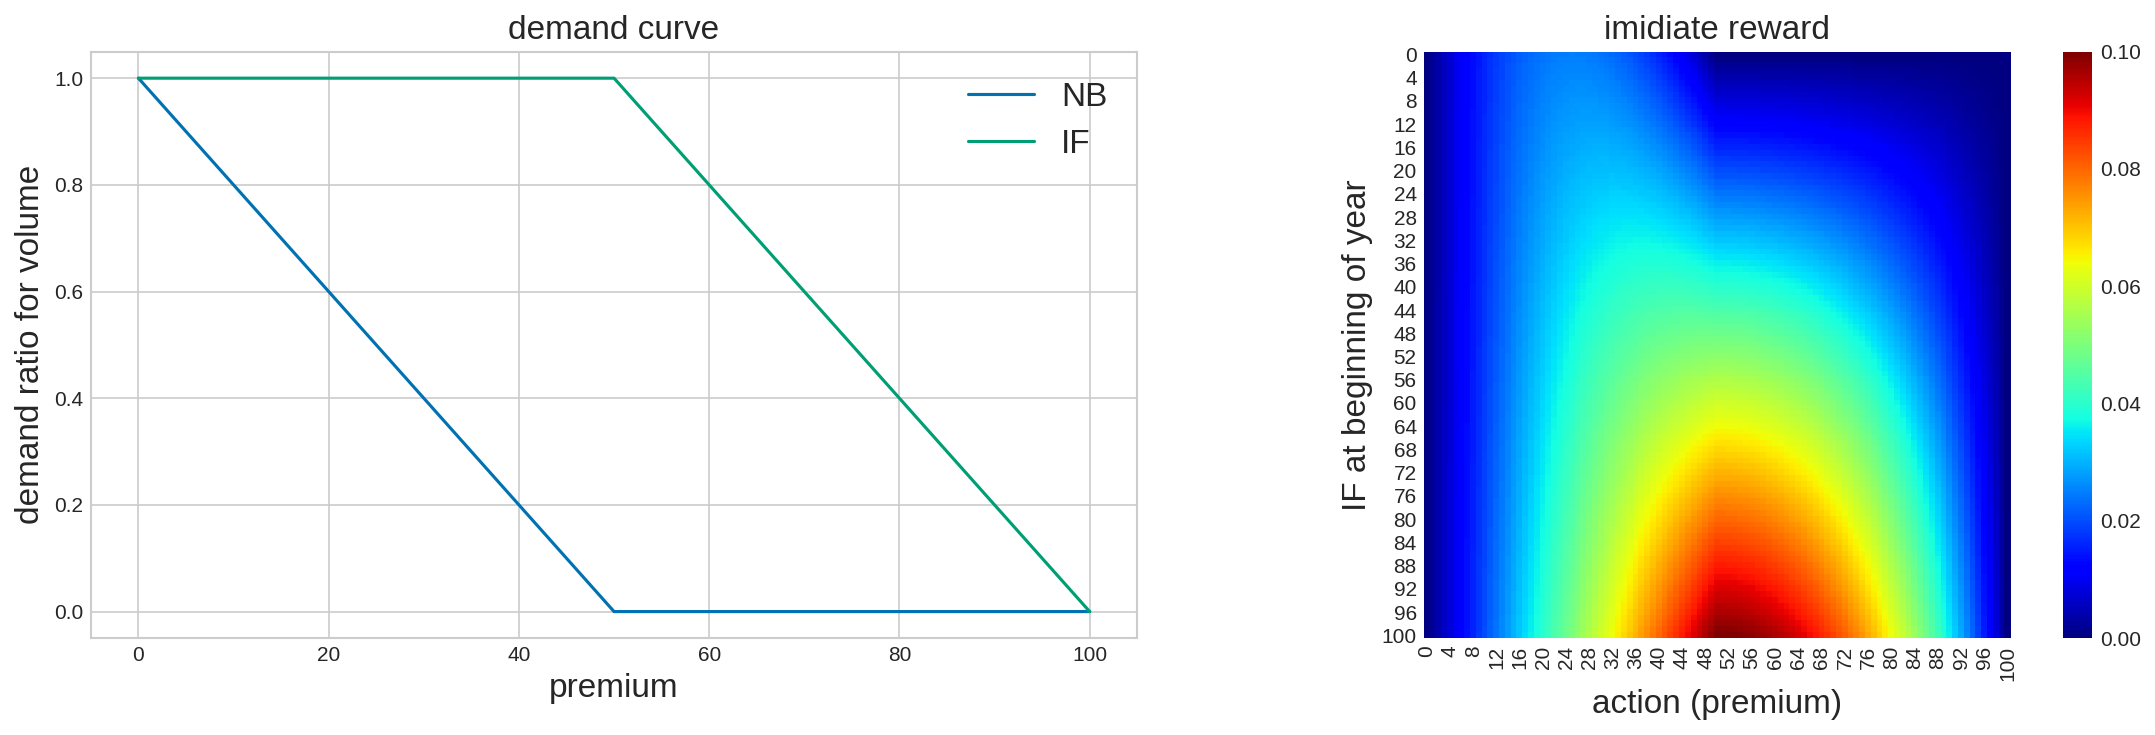

In [2]:
import Env_YRTRenewal
importlib.reload(Env_YRTRenewal)

env = Env_YRTRenewal.YRTRenewal(n_agents=1, term=10, 
                                expense_fixed=0/100, expense_variable=0/100)
env.show_demand()

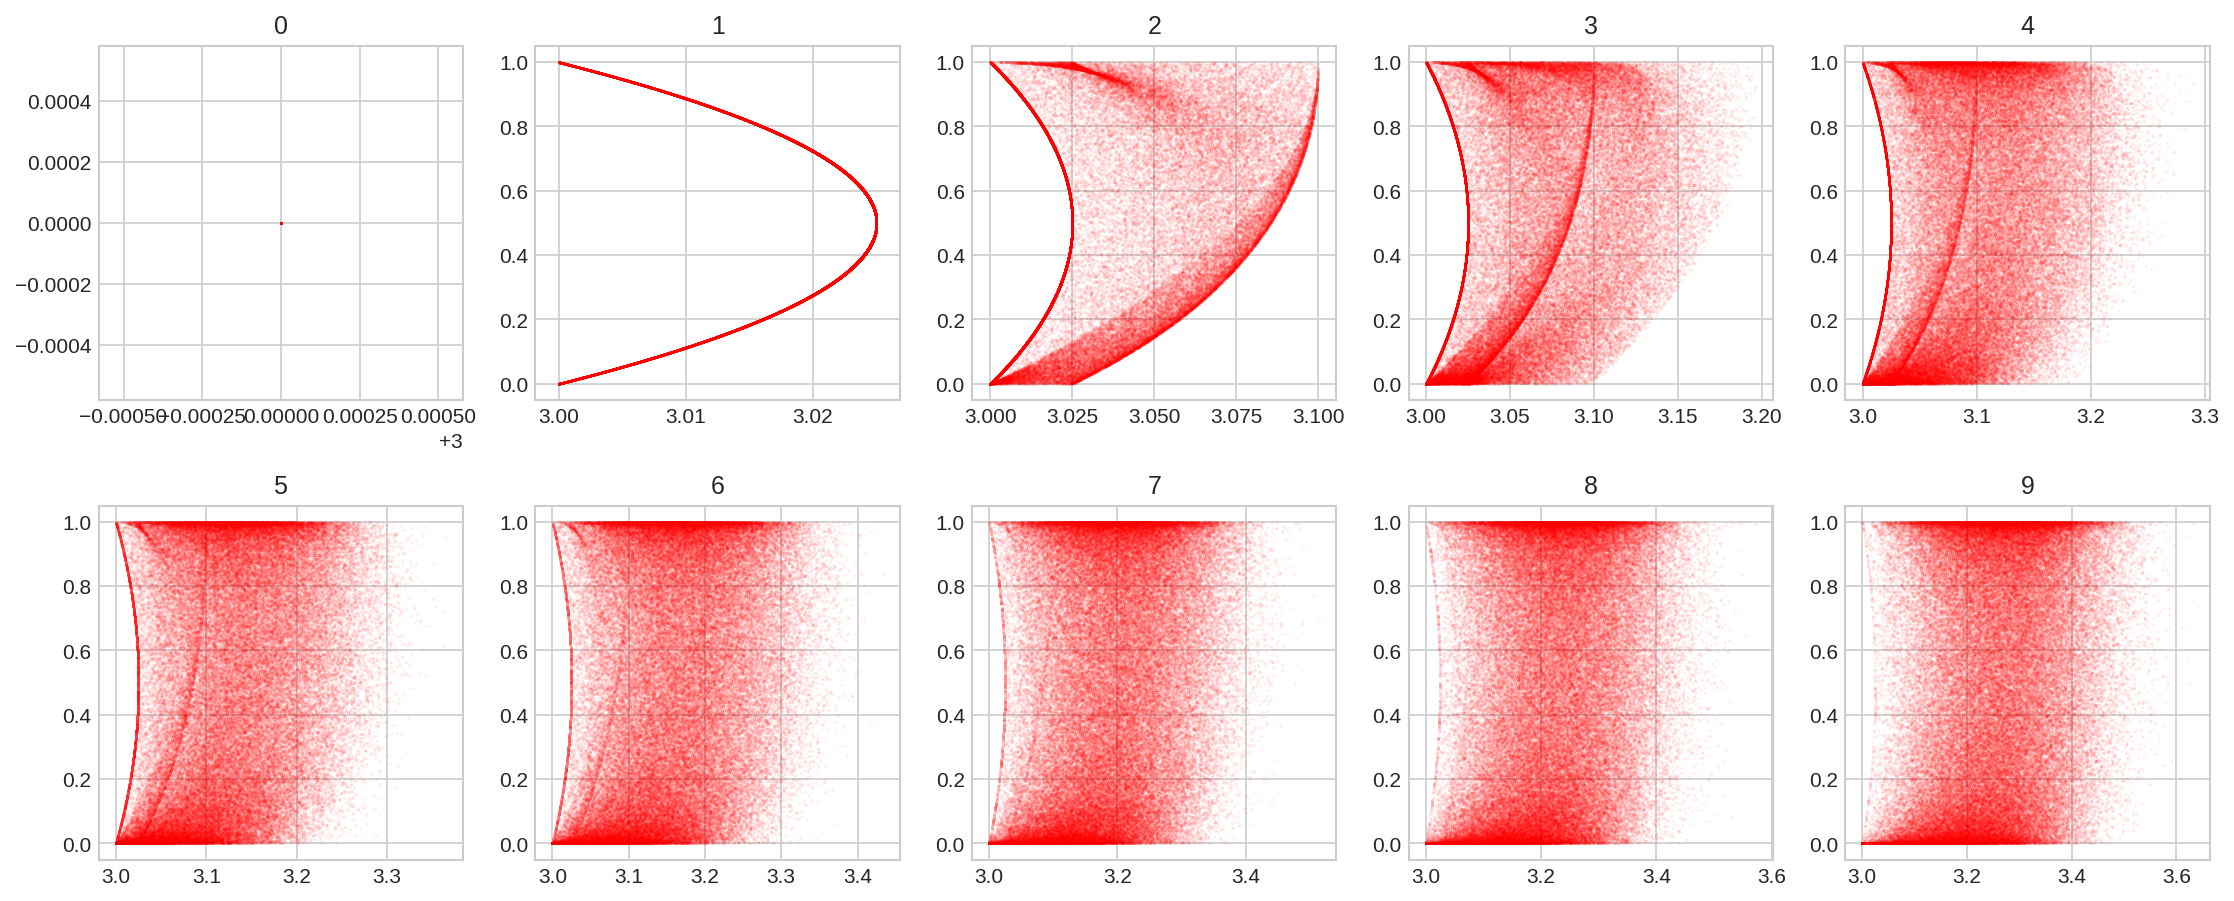

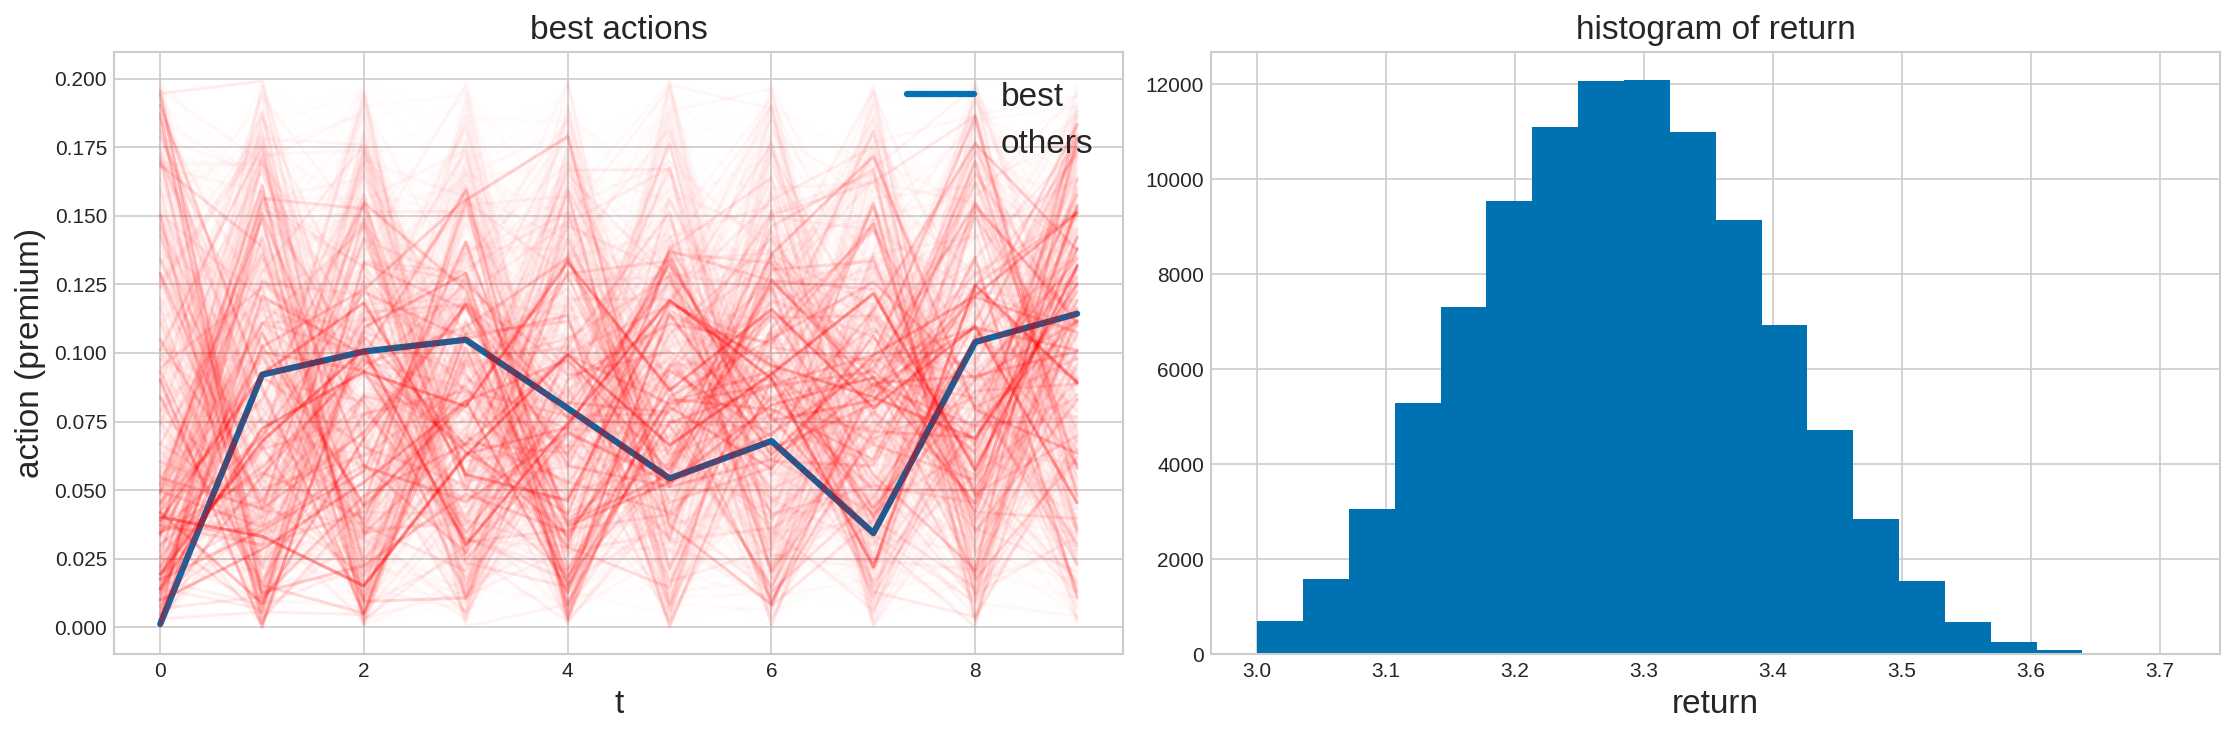

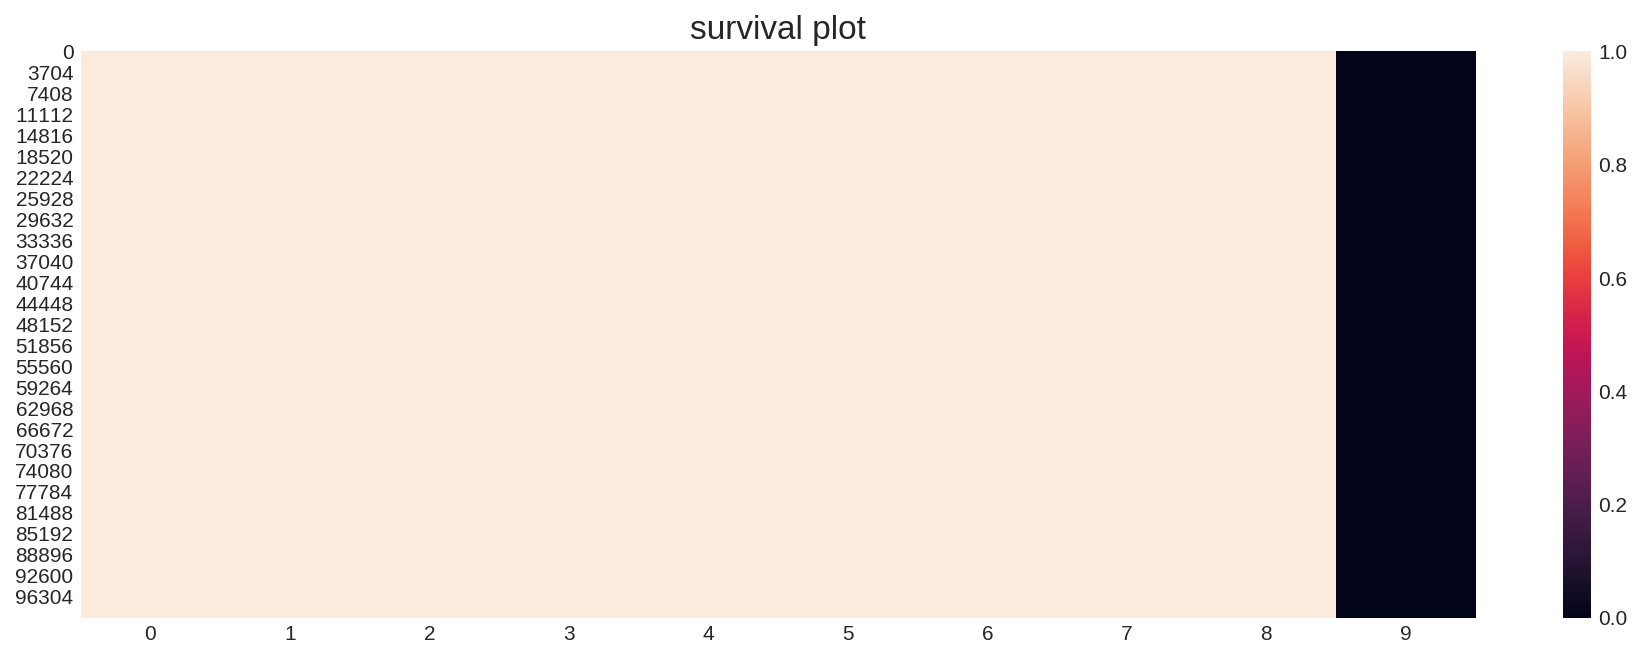

max(R) = 3.711, min(R) = 3.000, mean(R) = 3.283, std(R) = 0.110
survival ratio at end = 100.00%


In [3]:
env.show_simulation()

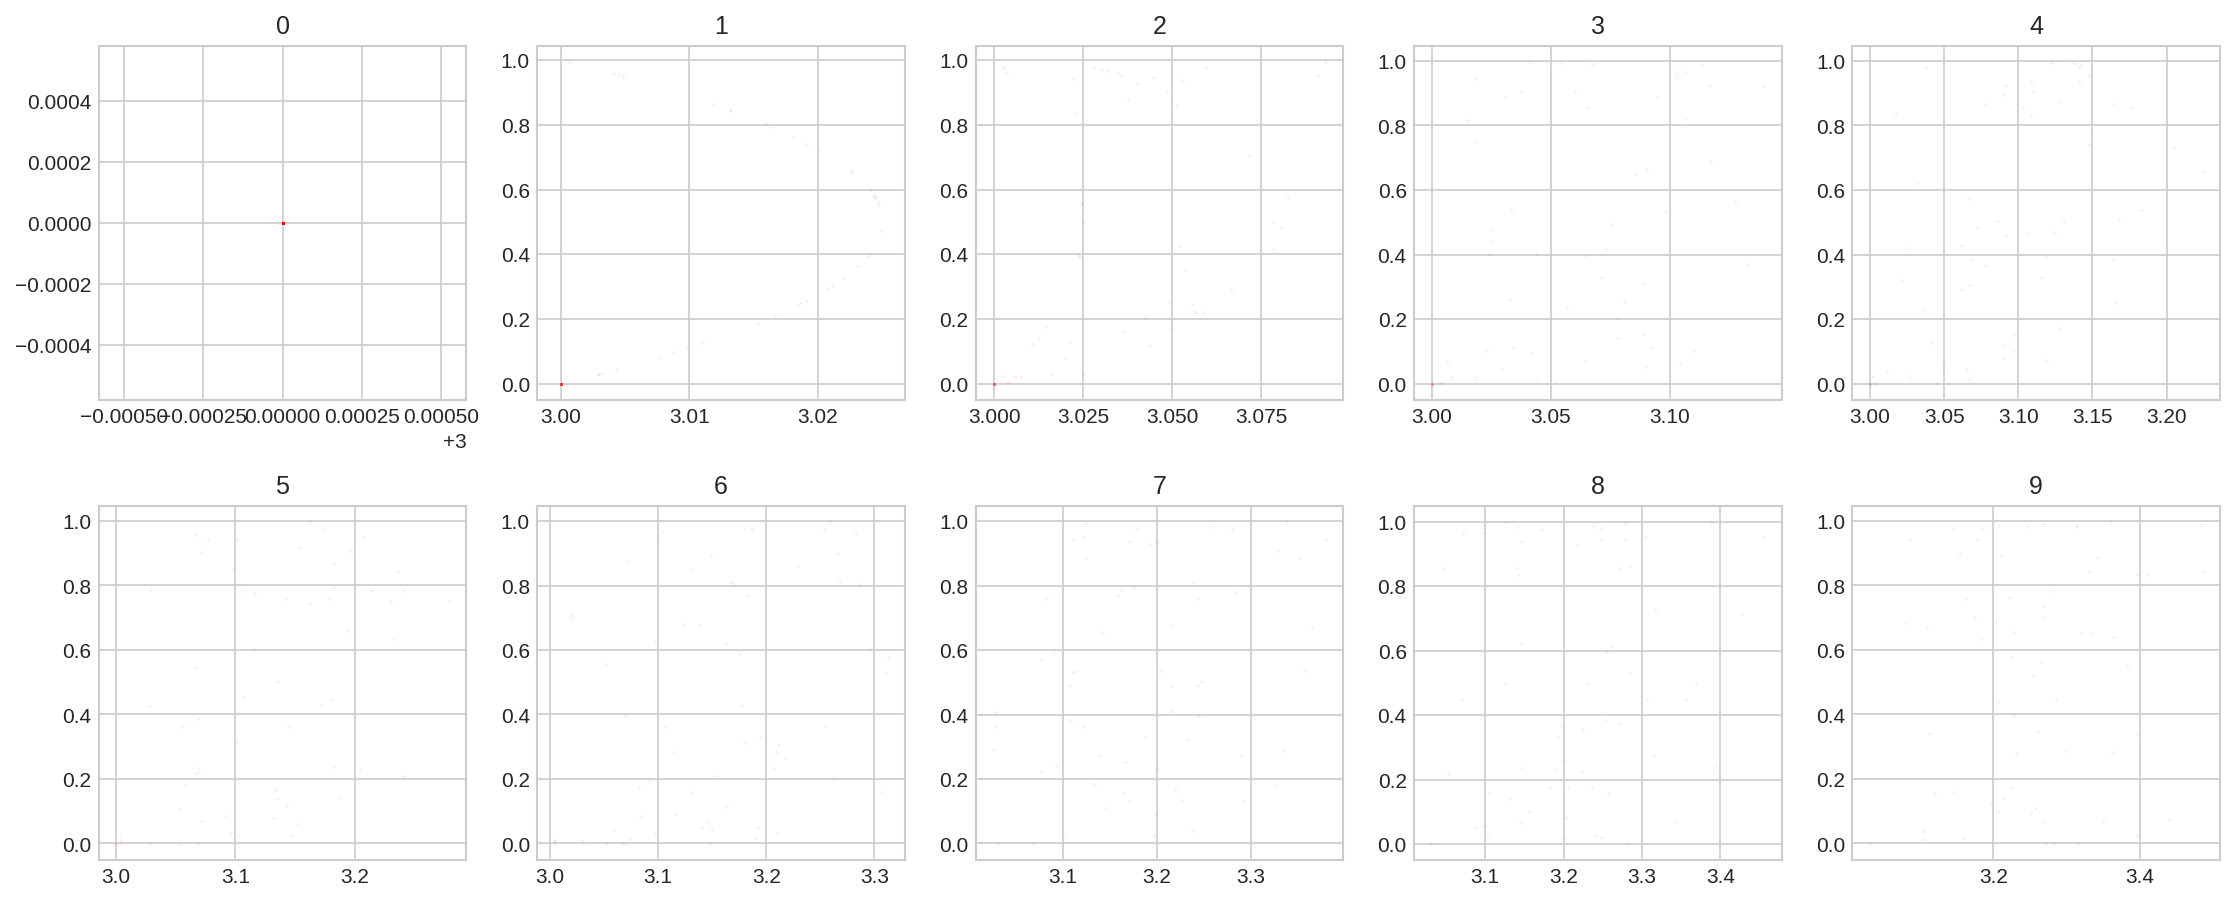

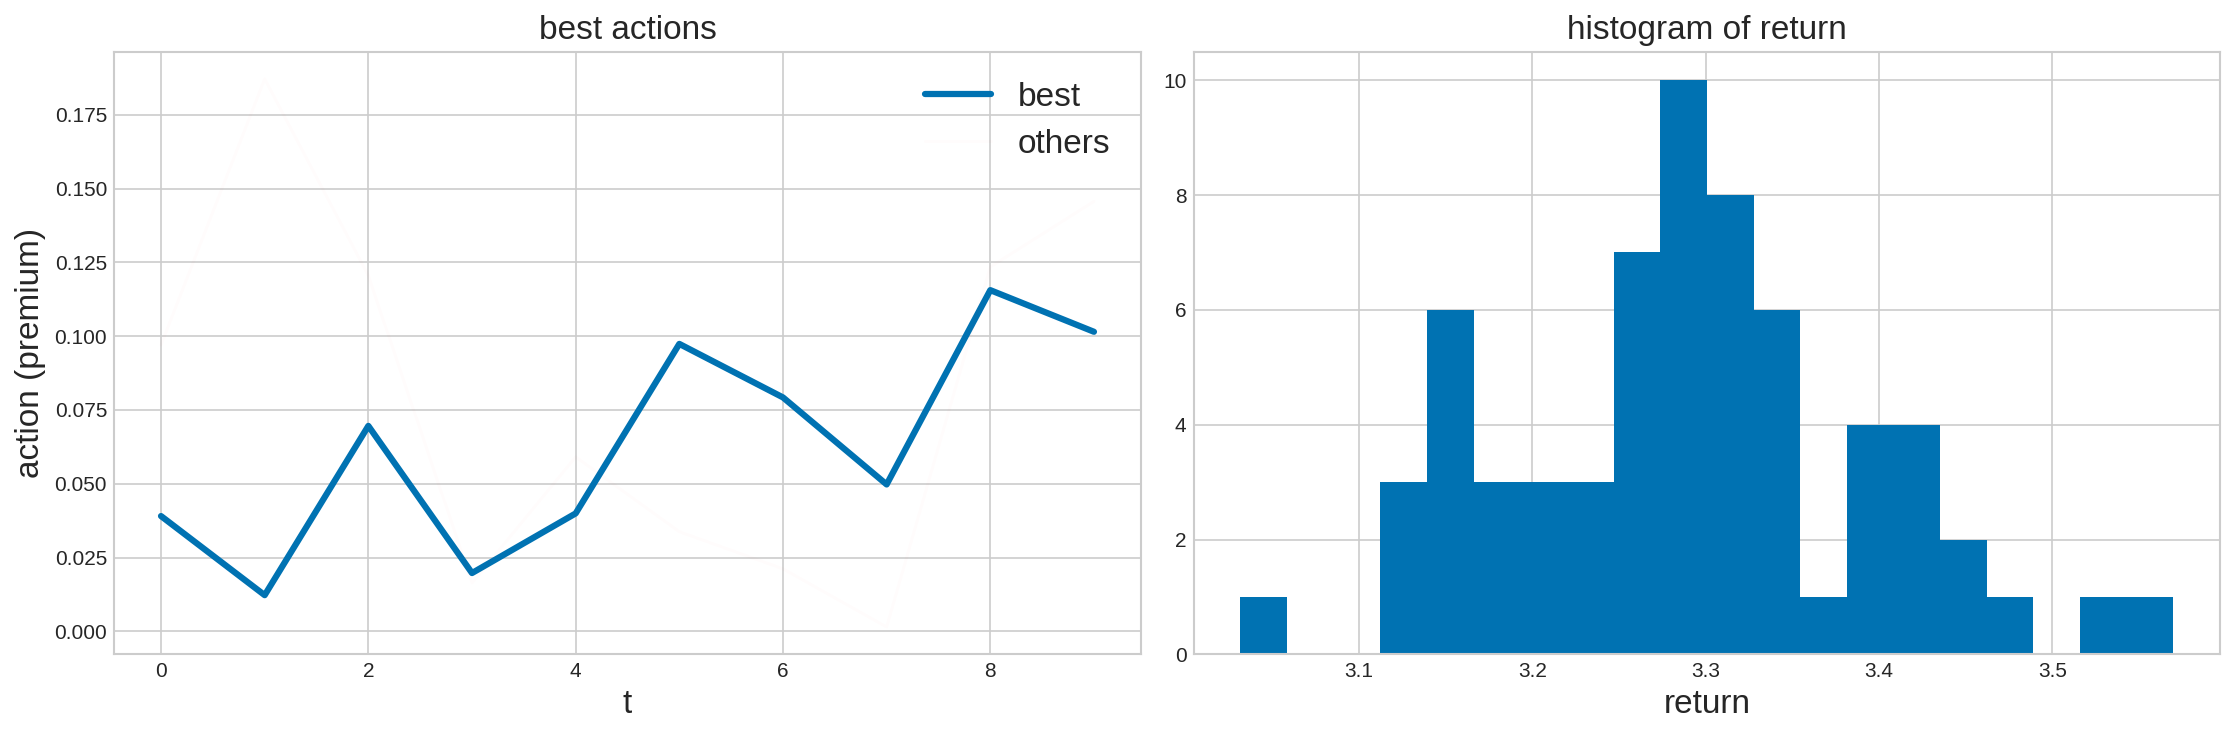

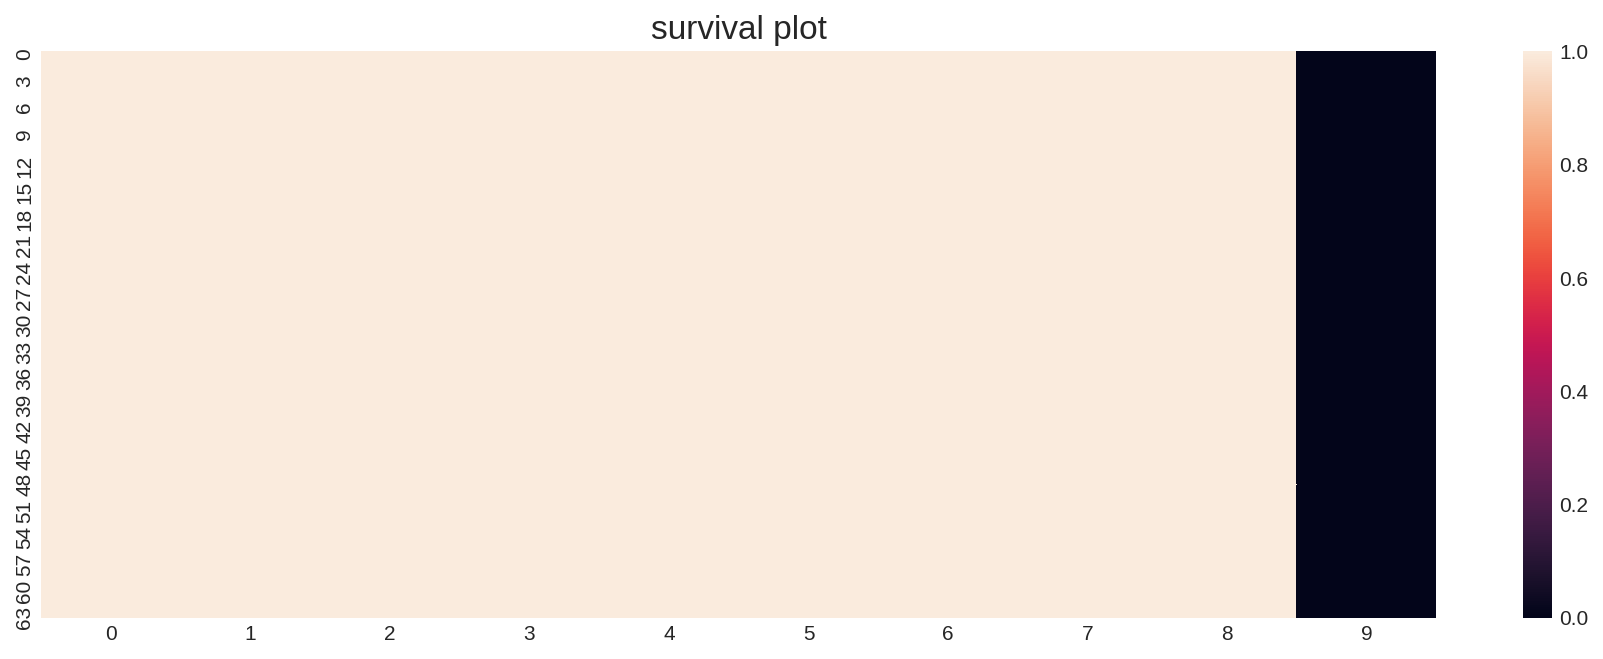

max(R) = 3.570, min(R) = 3.032, mean(R) = 3.289, std(R) = 0.105
survival ratio at end = 100.00%


In [4]:
env.show_simulation(n_agents=64)  # t=10相当

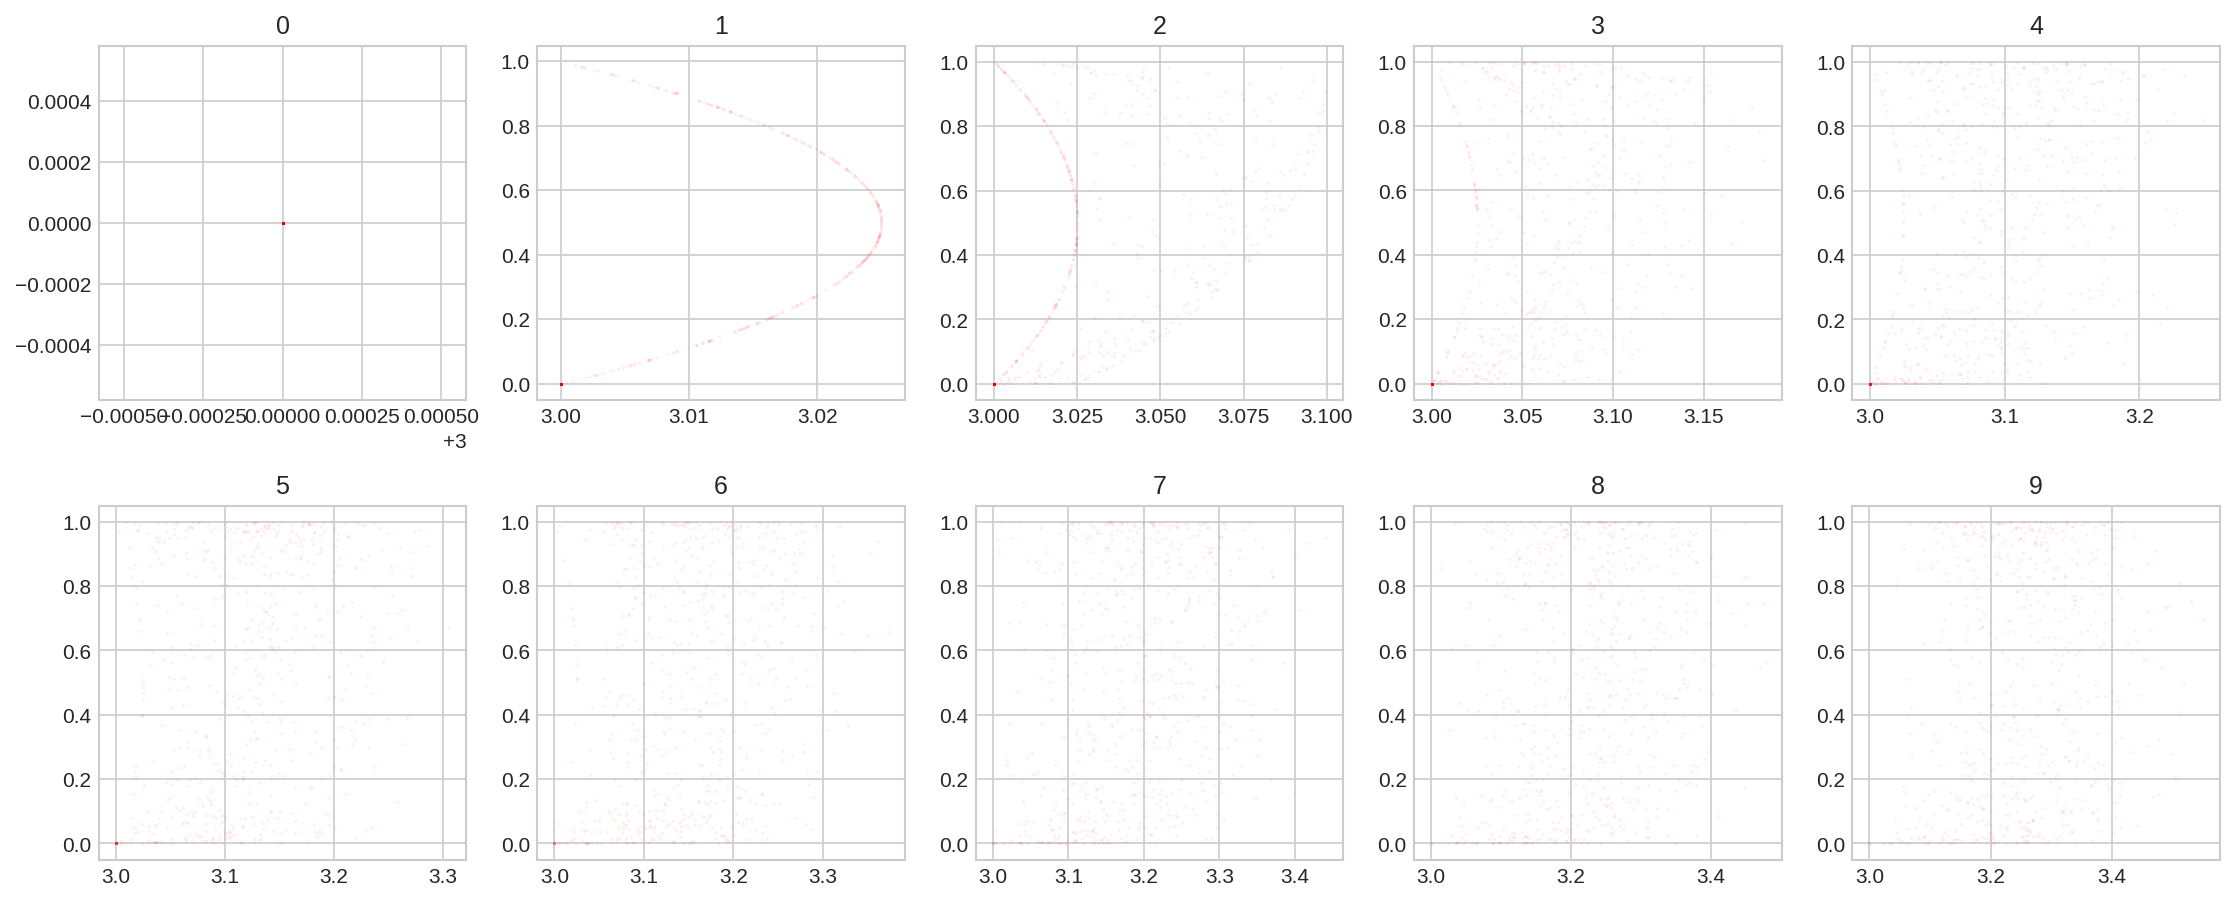

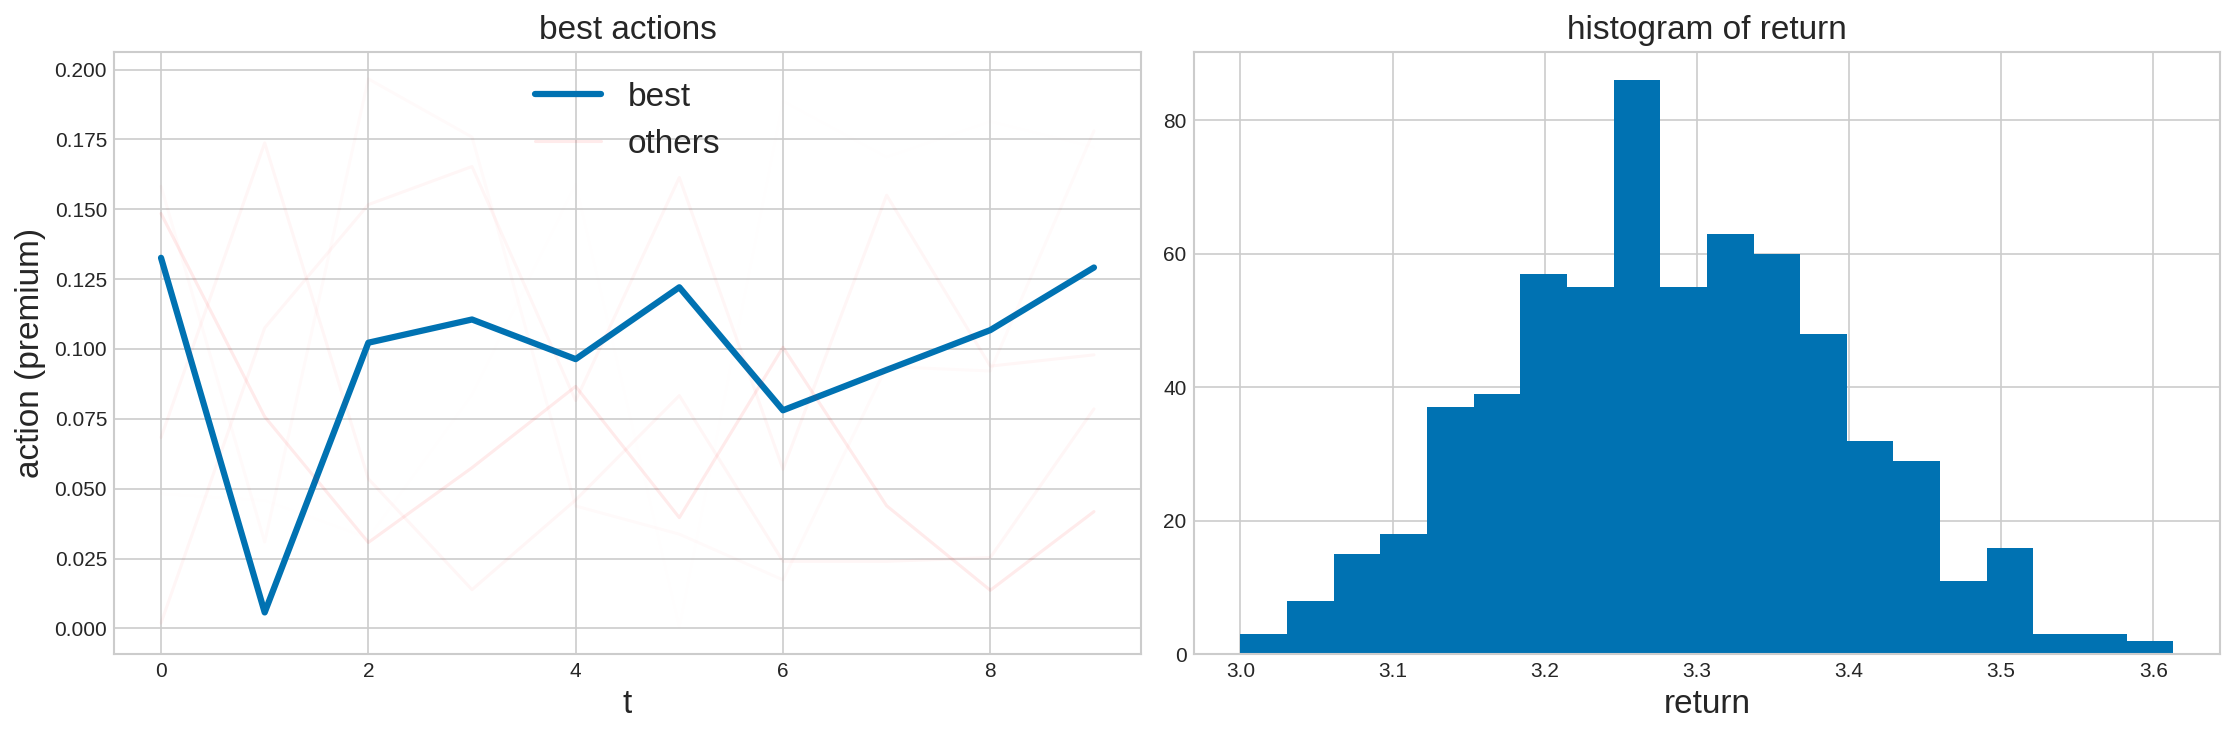

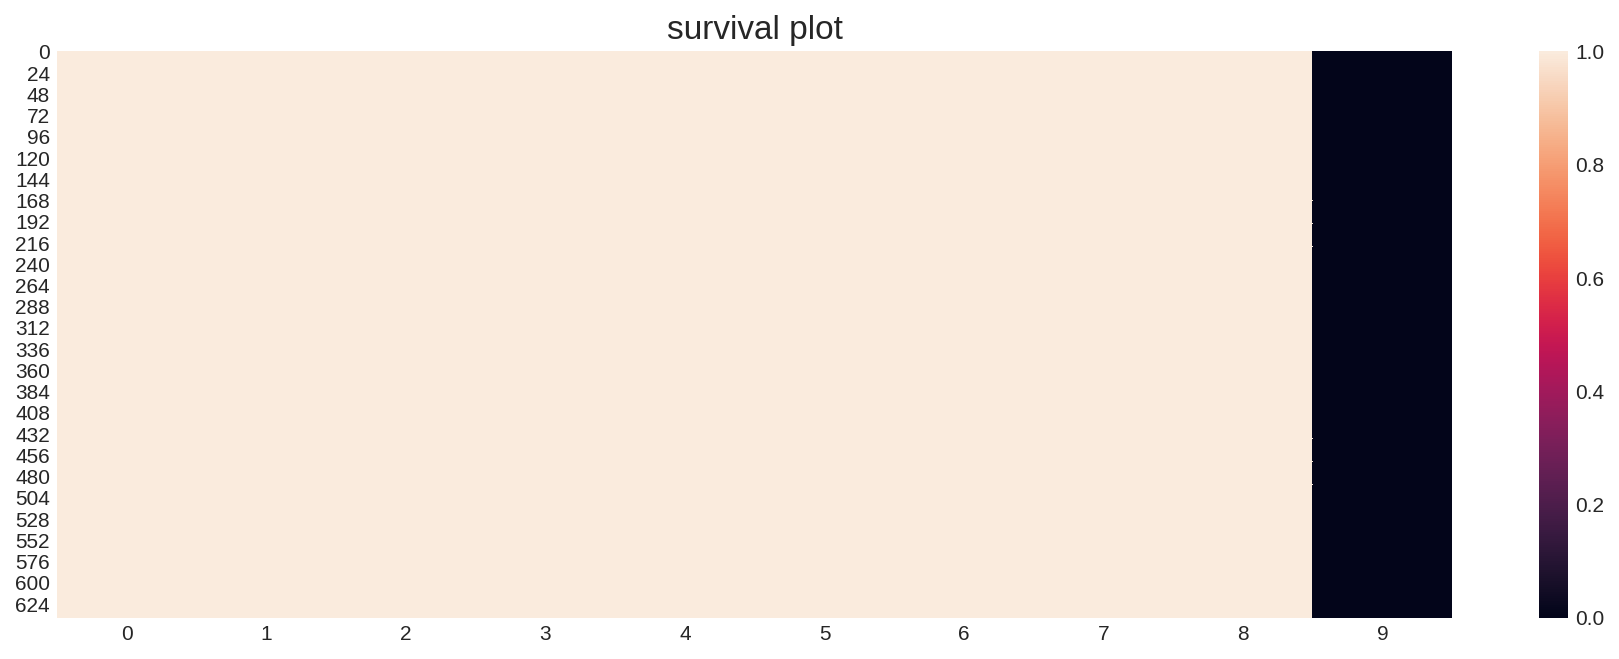

max(R) = 3.613, min(R) = 3.000, mean(R) = 3.283, std(R) = 0.110
survival ratio at end = 100.00%


In [5]:
env.show_simulation(n_agents=640)  # t=100相当

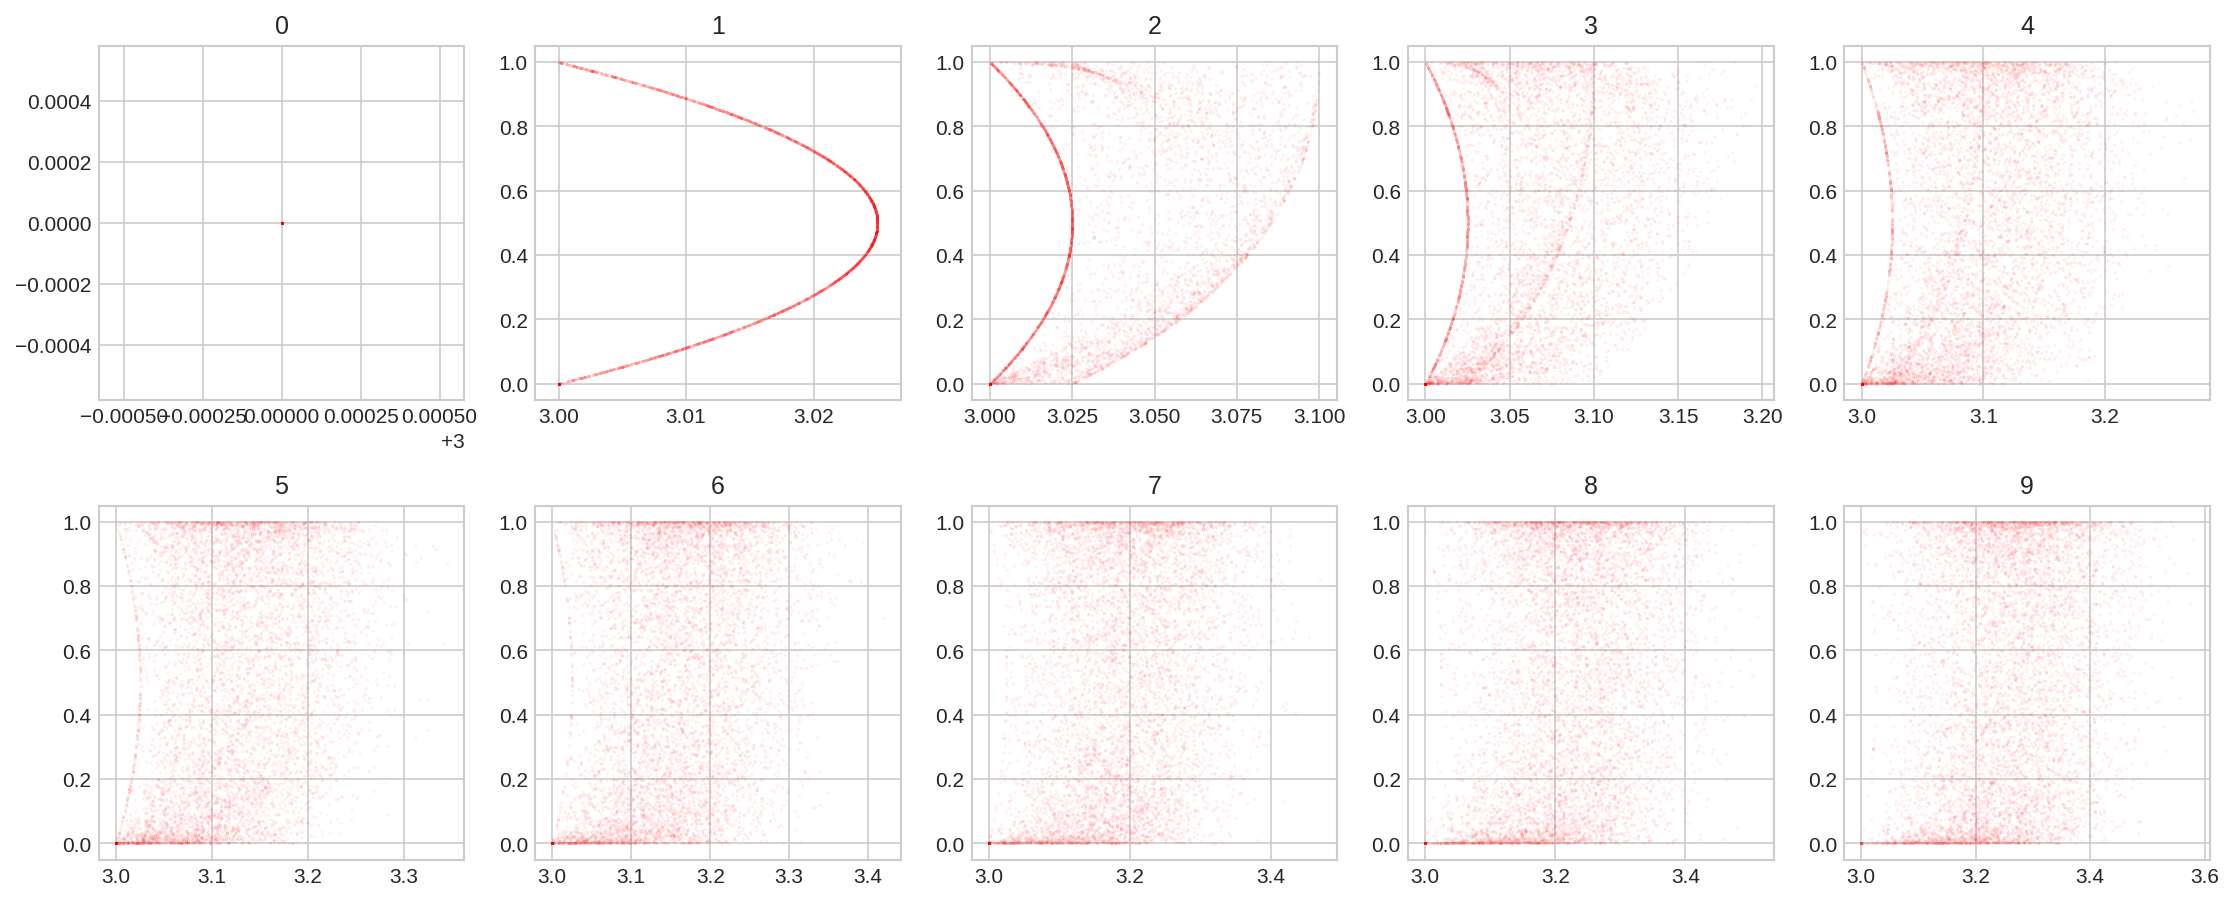

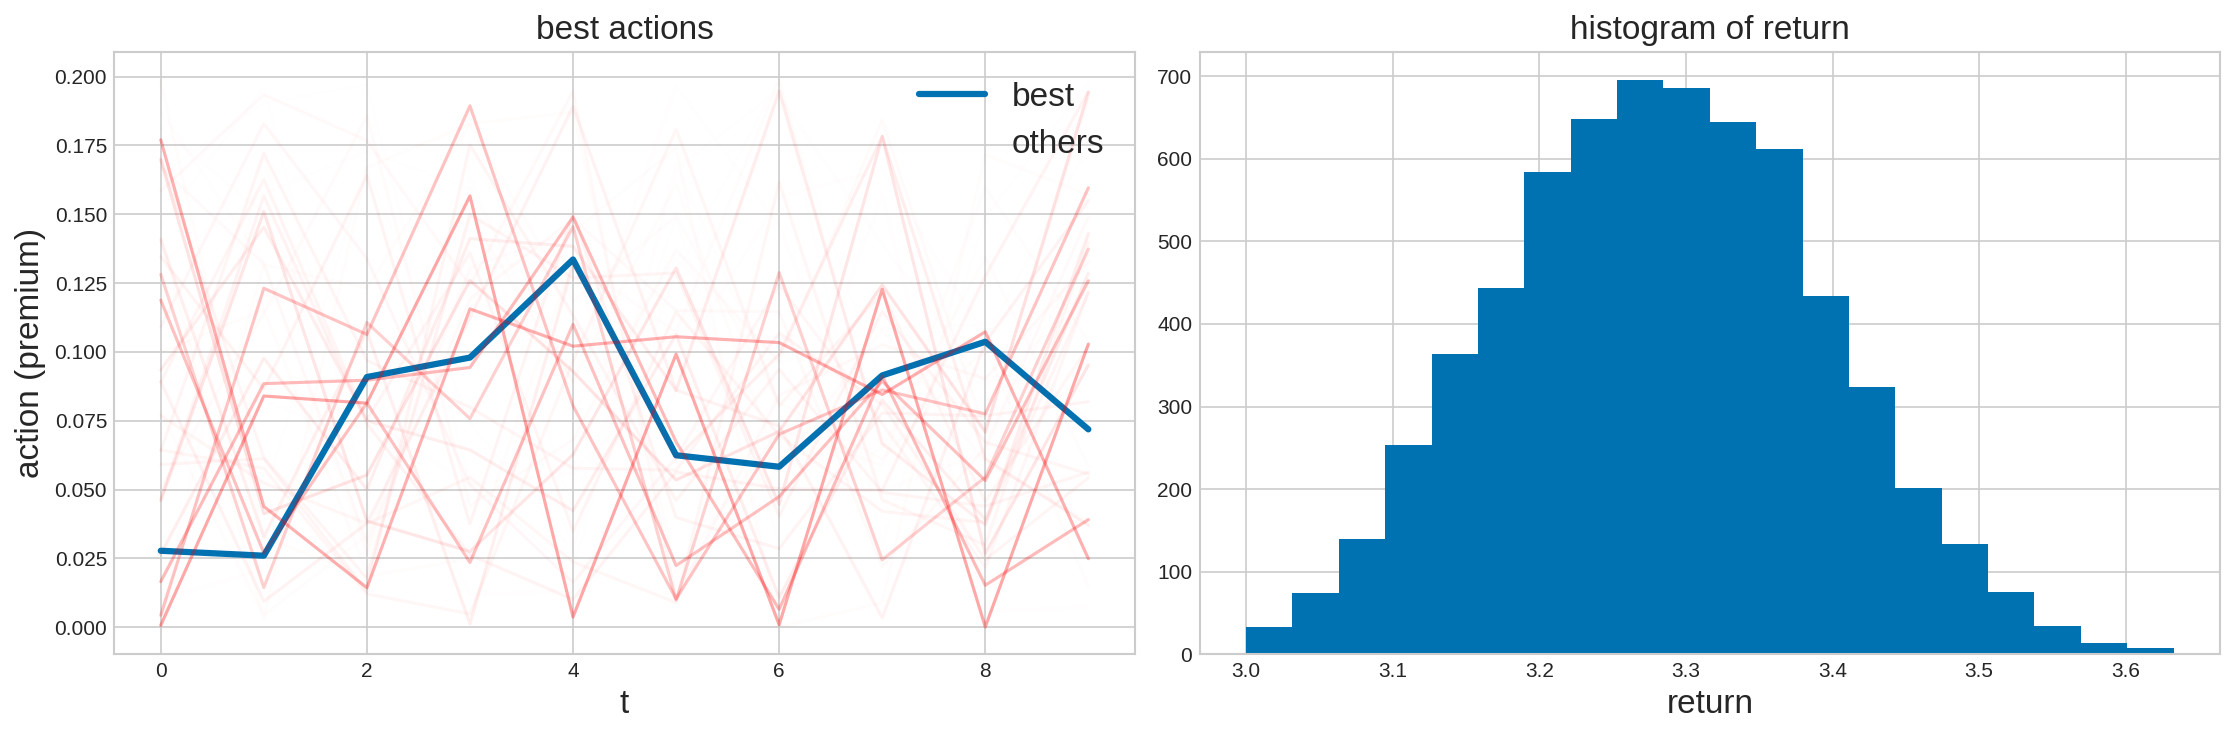

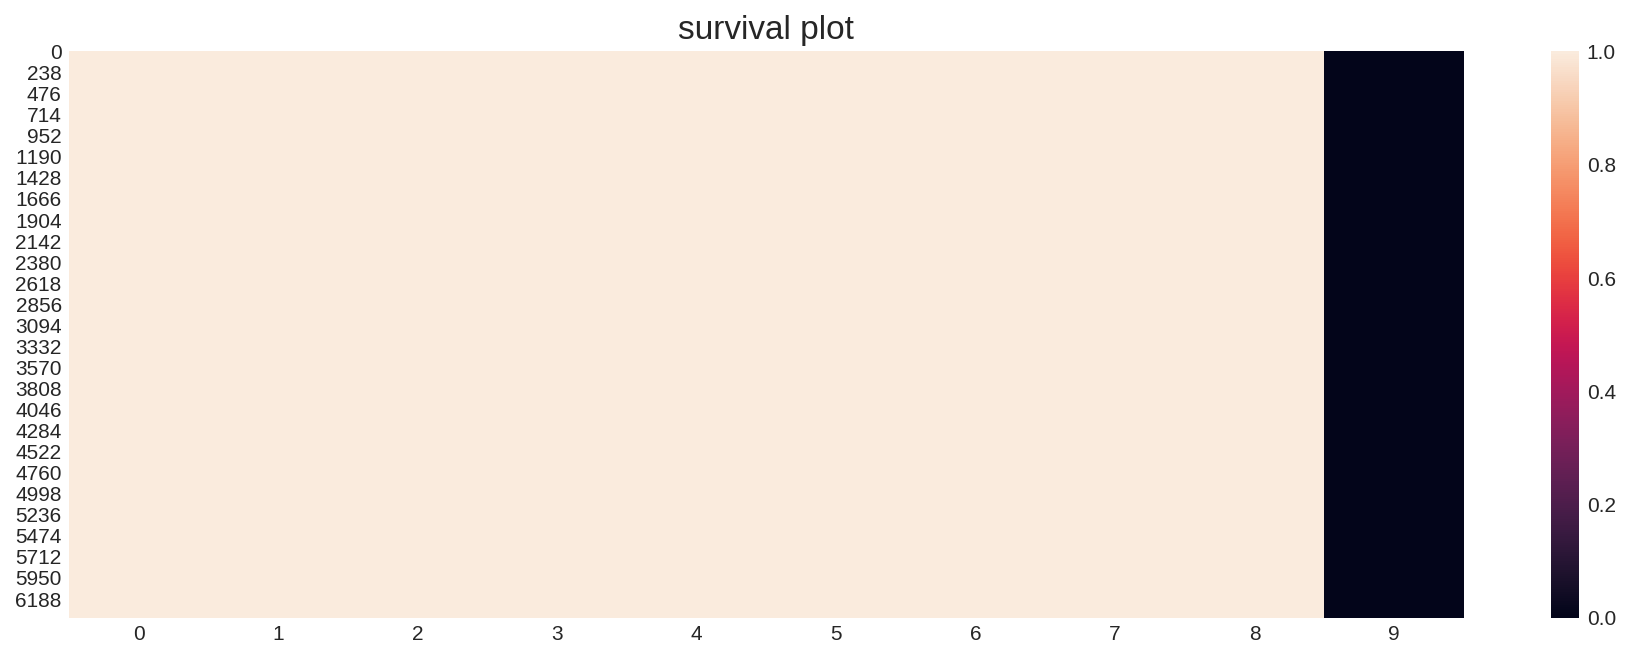

max(R) = 3.633, min(R) = 3.000, mean(R) = 3.283, std(R) = 0.109
survival ratio at end = 100.00%


In [6]:
env.show_simulation(n_agents=6400)  # t=1000相当

In [7]:
100 * (1000000 / 640000)

156.25

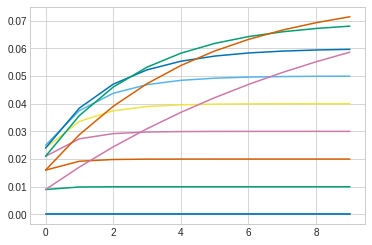

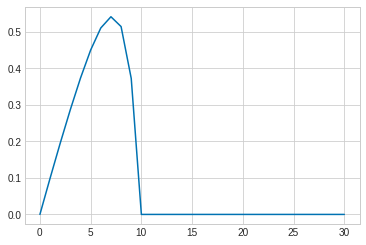

In [8]:
config = env.get_config()

X = []
Y = []
for a in np.arange(0, 31, 1):
    rewards = []
    for t in range(30):
        state_current = env.state()
        _, reward, _, done = env.step(np.array([[a,]]), verbose=False)
        rewards.append(reward[0][0])
        if done[0][0]==True:
            plt.plot(rewards, label=a)
            rewards = np.array(rewards).sum()
            X.append(a)
            Y.append(rewards)
            break

    #print('action=',a, 'reward=', rewards)
#plt.legend()
plt.show()

plt.plot(np.array(X), np.array(Y))
plt.show()


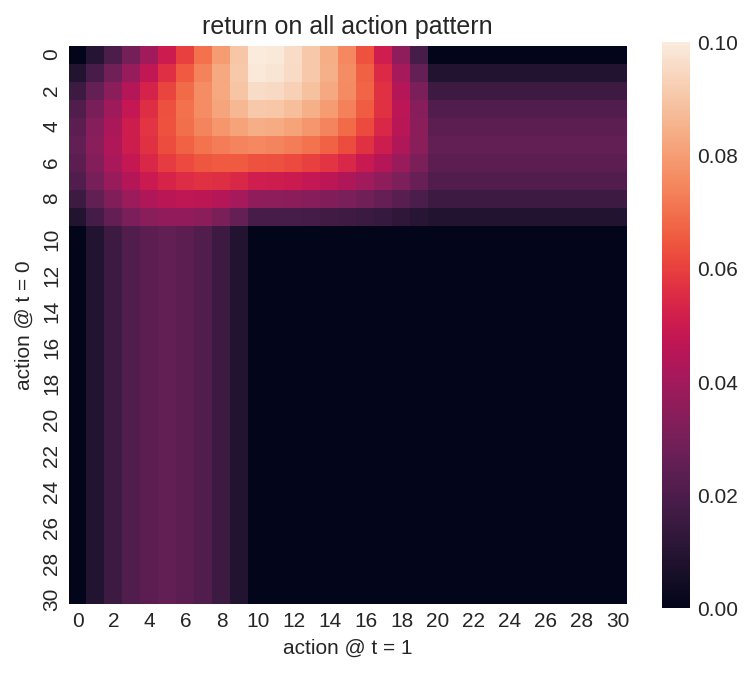

In [9]:
# 2期間の場合の利得の全探索．
env = Env_YRTRenewal.YRTRenewal(n_agents=1, term=2)
scores = np.zeros(shape=(31, 31))
for a1 in range(31):
    for a2 in range(31):
        env.reset()
        _, reward1, _, _ = env.step(np.array(a1))
        _, reward2, _, _ = env.step(np.array(a2))
        scores[a1, a2] = reward1 + reward2

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)
sns.heatmap(scores, ax=ax, square=True)
ax.set_title('return on all action pattern')
ax.set_xlabel('action @ t = 1')
ax.set_ylabel('action @ t = 0')

plt.show()

In [10]:
print(env.get_config())
print(env.mult_action)

{'n_agents': 1, 'term': 2, 'total_volume': 1, 'prm_min_NB': 0.0, 'prm_max_NB': 0.1, 'ratio_NB_max': 1.0, 'prm_min_IF': 0.1, 'prm_max_IF': 0.2, 'ratio_IF_max': 1.0, 'expense_fixed': 0.0, 'expense_variable': 0.0, 'interest': 0.0, 'initial_cash': 3.0}
0.01


---
## 2. Start testing on Agents

In [11]:
(1 * 64 * 100) // 256

25

In [12]:
TERM = 10

In [13]:
n_trials = 5

n_batches = lambda x: (x * 64 * 1000) // 256
df = pd.DataFrame()

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W1106 00:07:57.149848 140688648431424 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1106 00:07:57.150621 140688648431424 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1106 00:07:57.154829 

lr=0.001, eps=1.0, boltzmann=False
start testing... :  2019-11-06 00:07:57.226807
start trial 1/5 trial...


W1106 00:07:57.529864 140688648431424 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

  0%|          | 0/1 [00:00<?, ?it/s]

start trial 2/5 trial...


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


start trial 3/5 trial...


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


start trial 4/5 trial...


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


start trial 5/5 trial...


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


end testing... :  2019-11-06 00:08:04.560552
loss and reward history


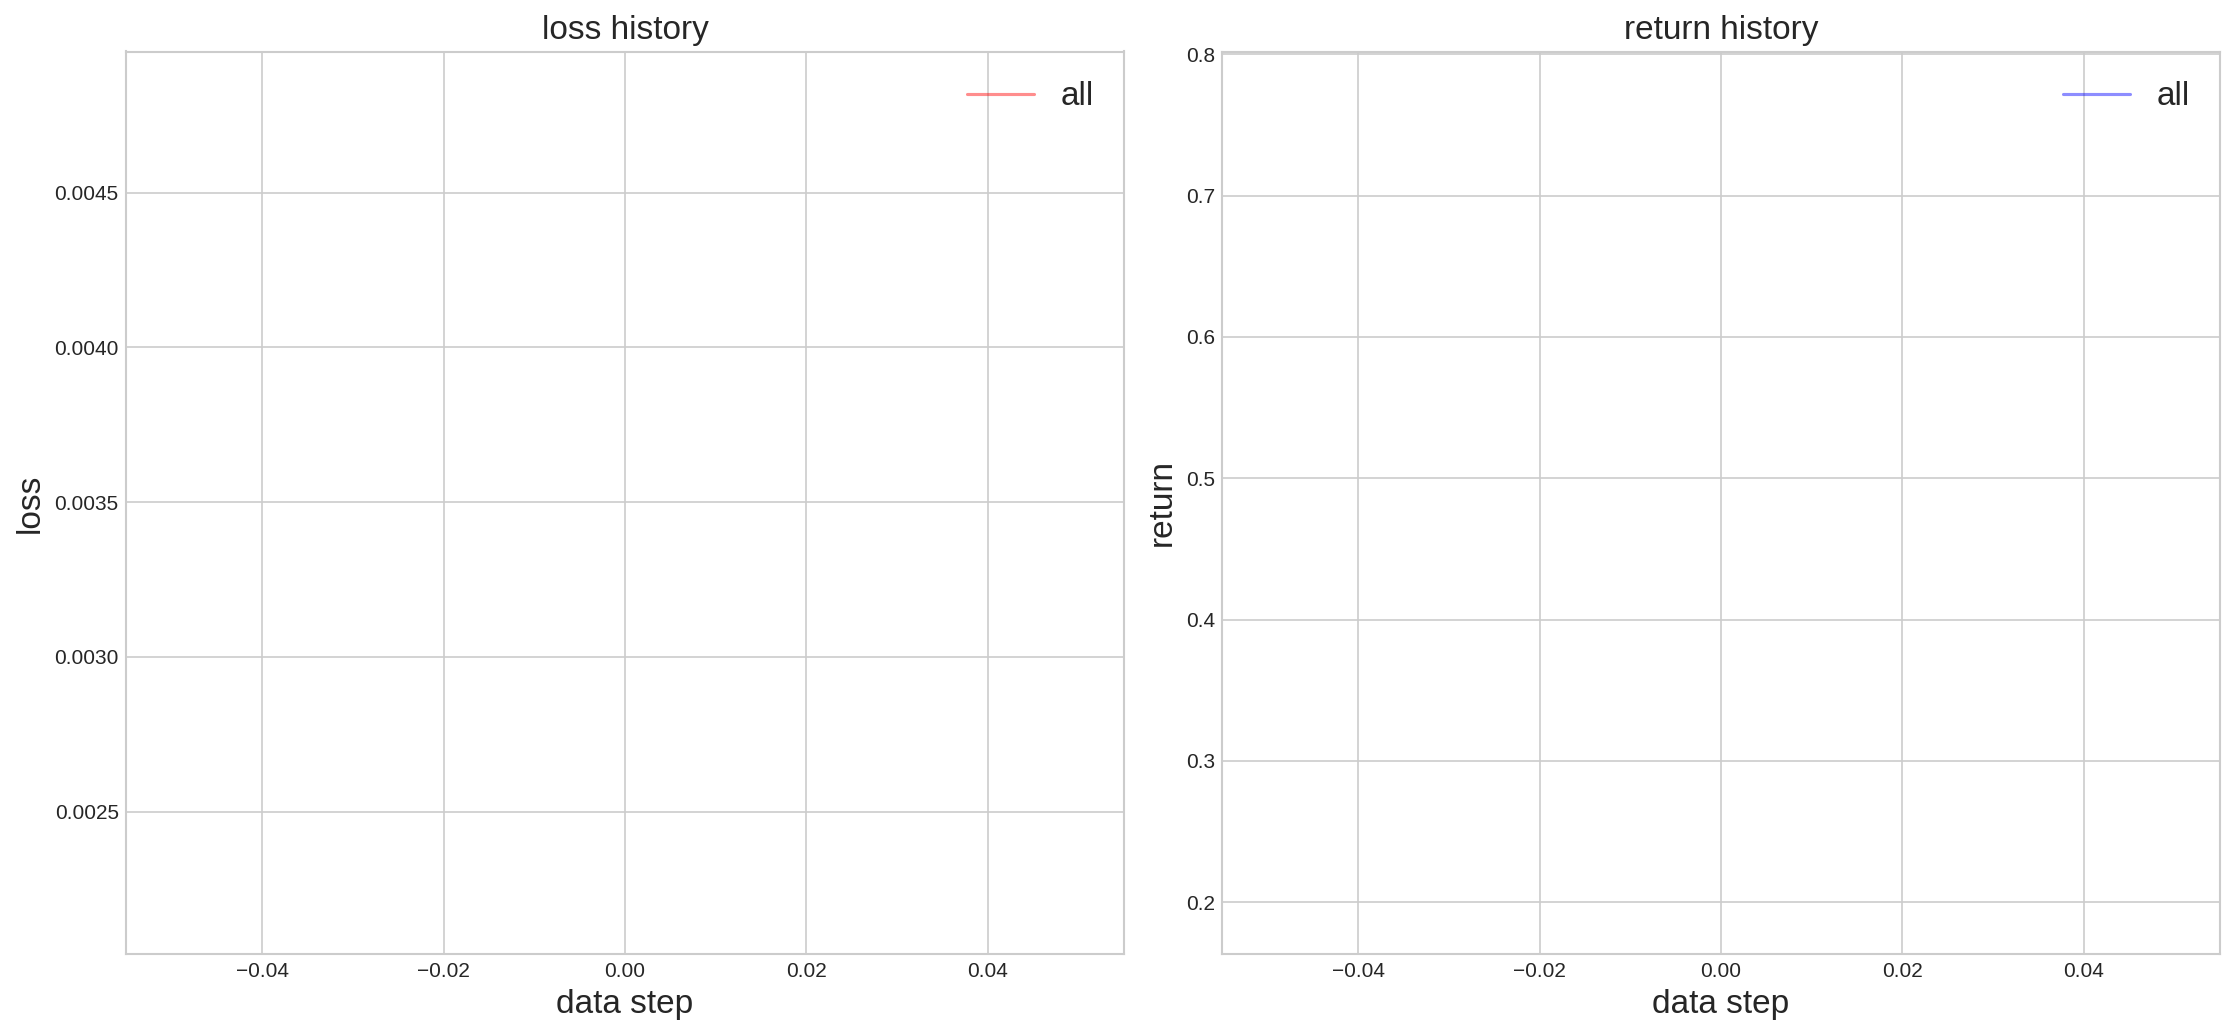

acquired action
action =  [13 13 13 13 13 13 13 13 13 13]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [13 13 13 13 13 13 13 13 13 13]
action =  [13 13 13 13 13 13 13 13 13 13]
action =  [13 13 13 13 13 13 13 13 13 13]
action =  [5 5 5 5 5 5 5 5 5 5]
action =  [5 5 5 5 5 5 5 5 5 5]
action =  [5 5 5 5 5 5 5 5 5 5]
action =  [20 20 20 20 20 20 20 20 20 20]
action =  [20 20 20 20 20 20 20 20 20 20]
return [0.216 0.216 0.216 0.216 0.216 0.216 0.216 0.216 0.216 0.216]
param distribution in model


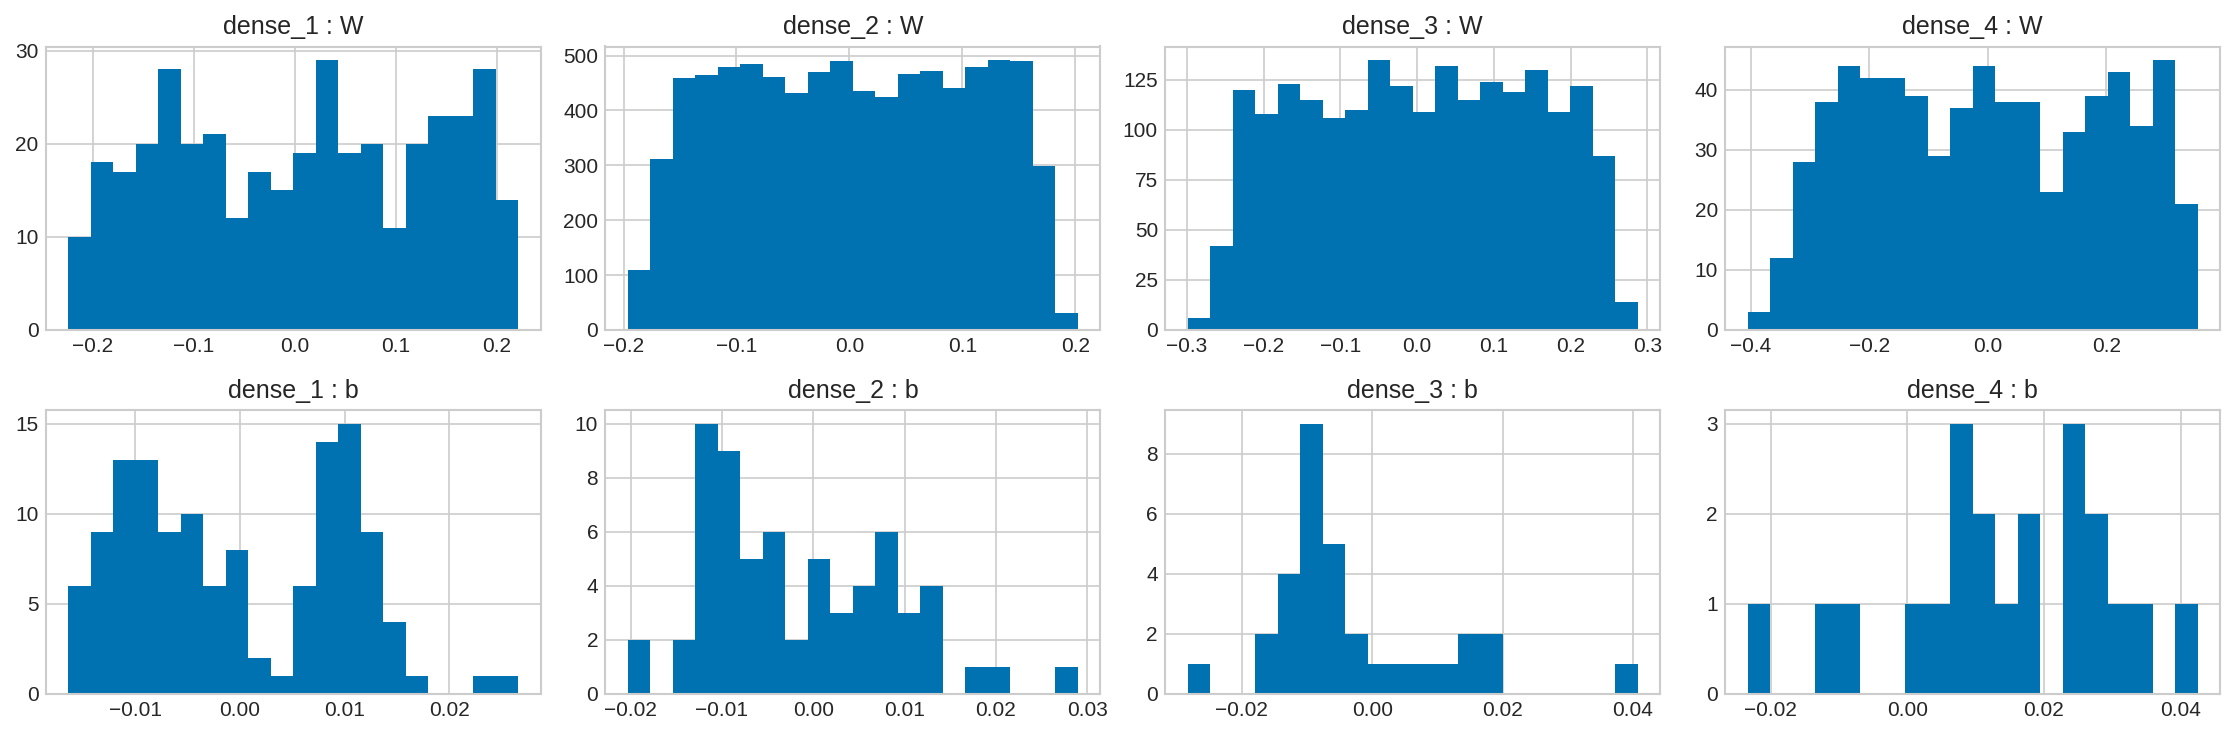

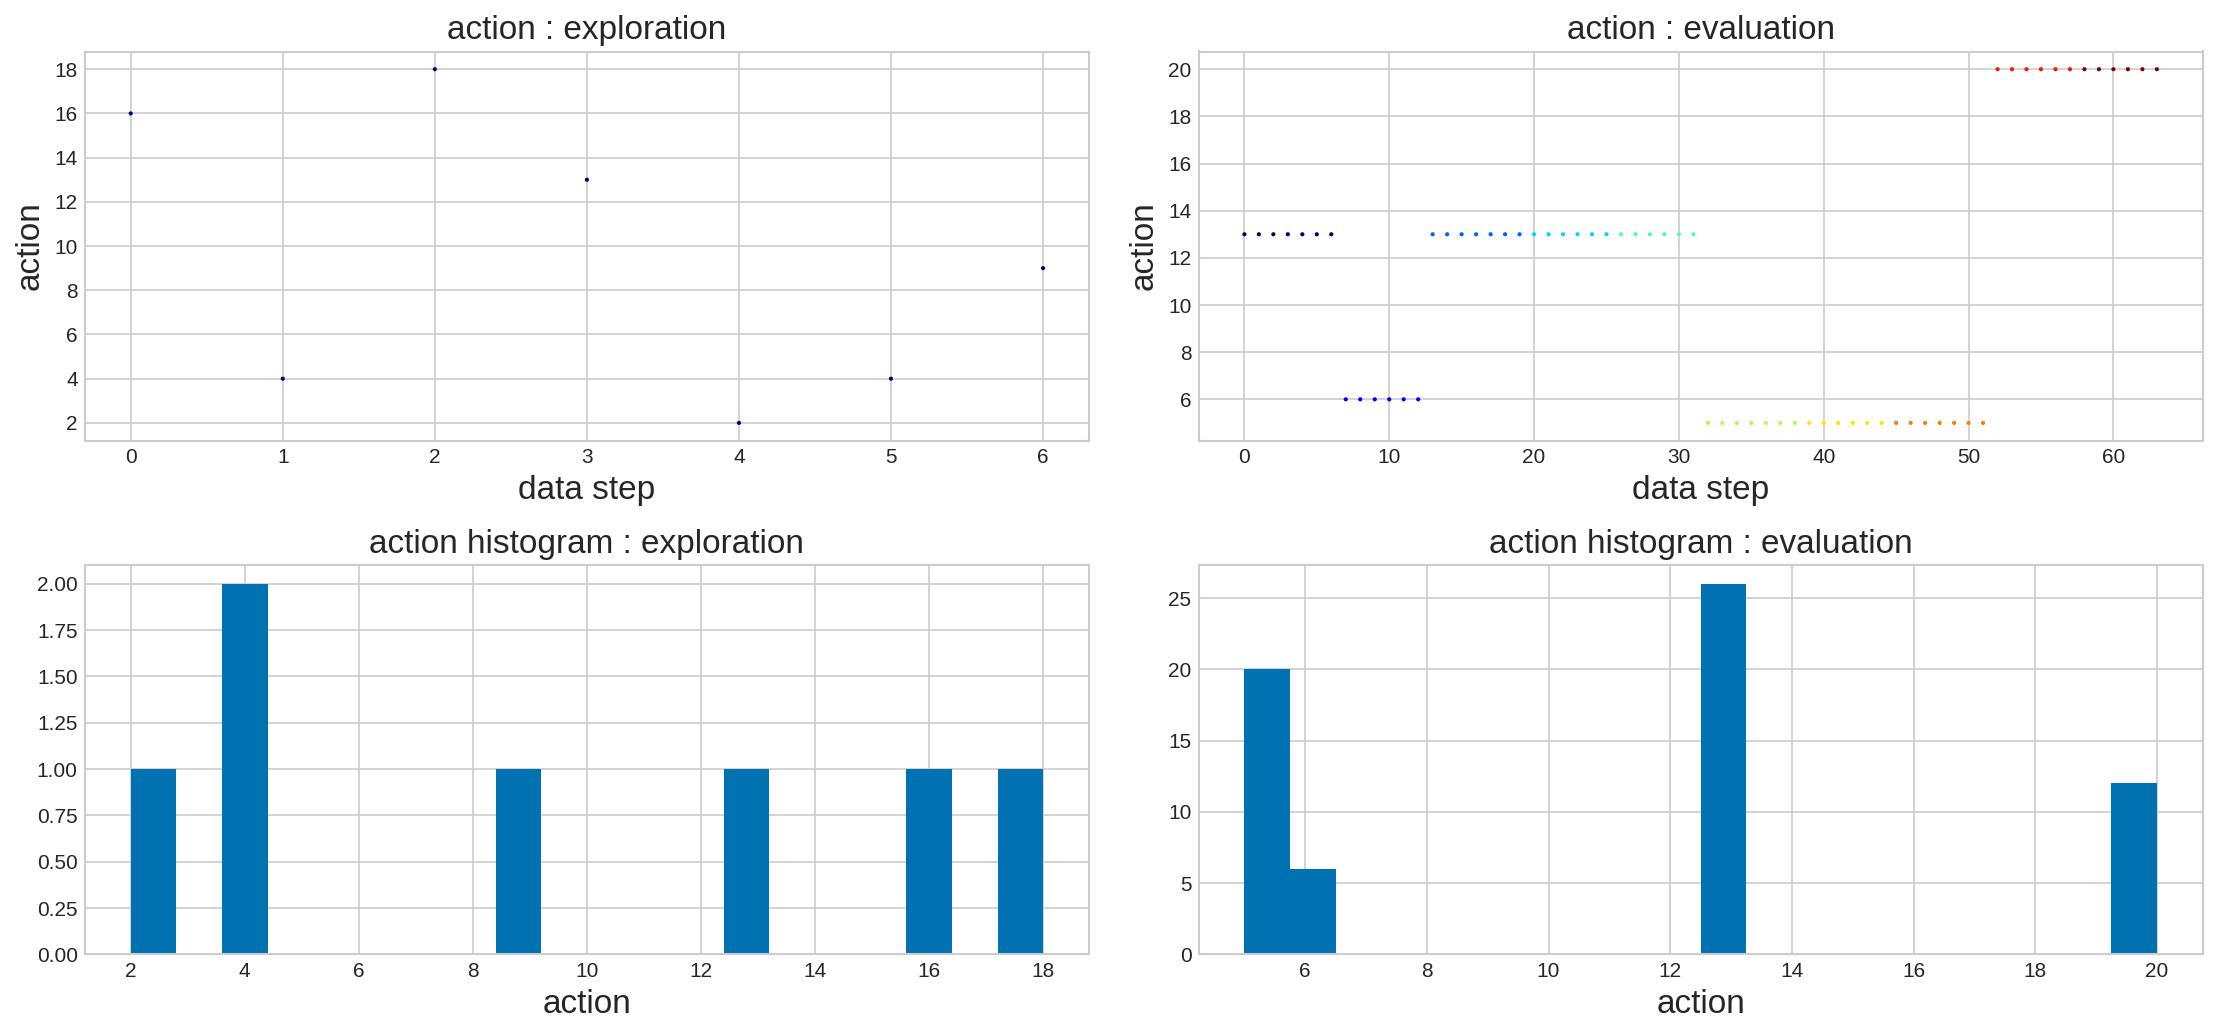

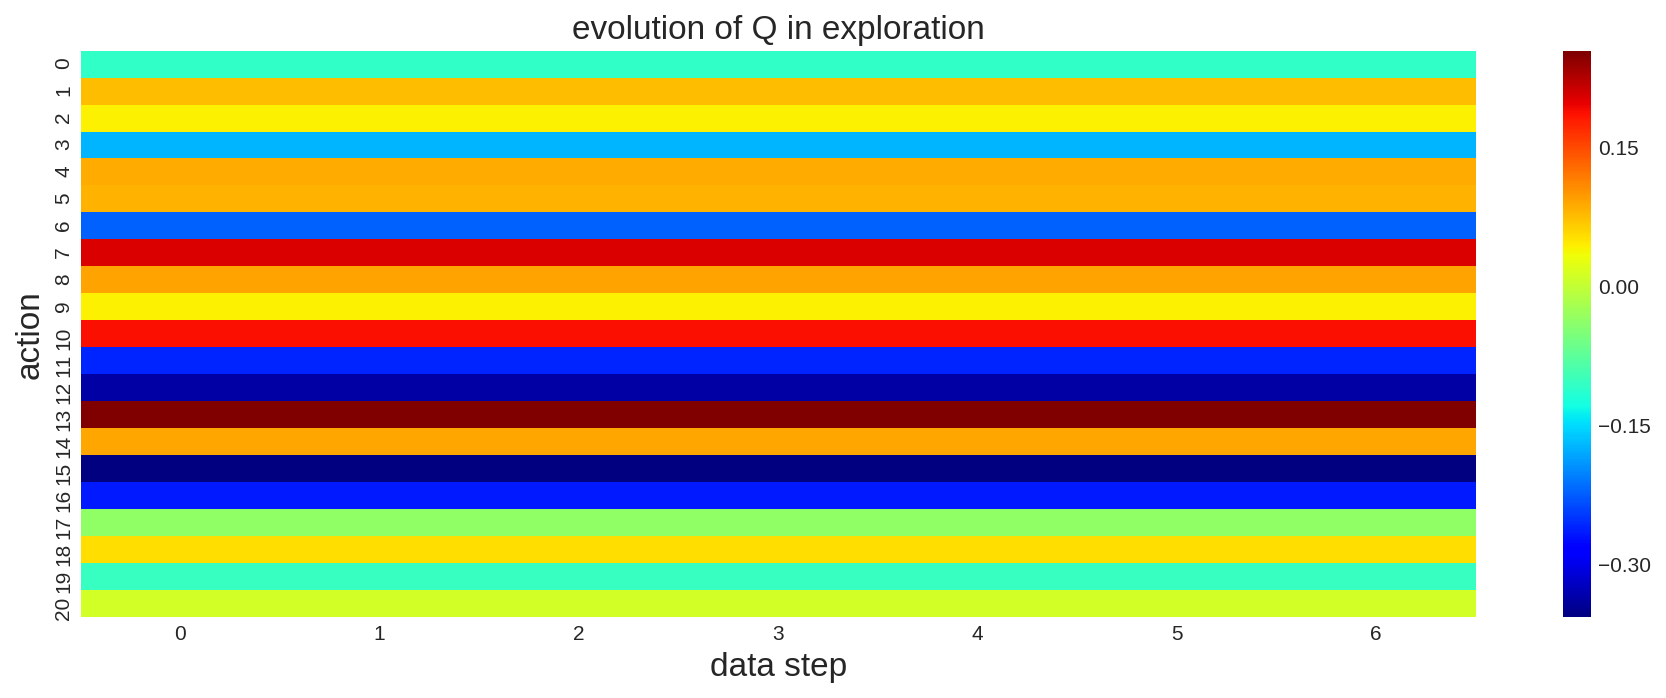

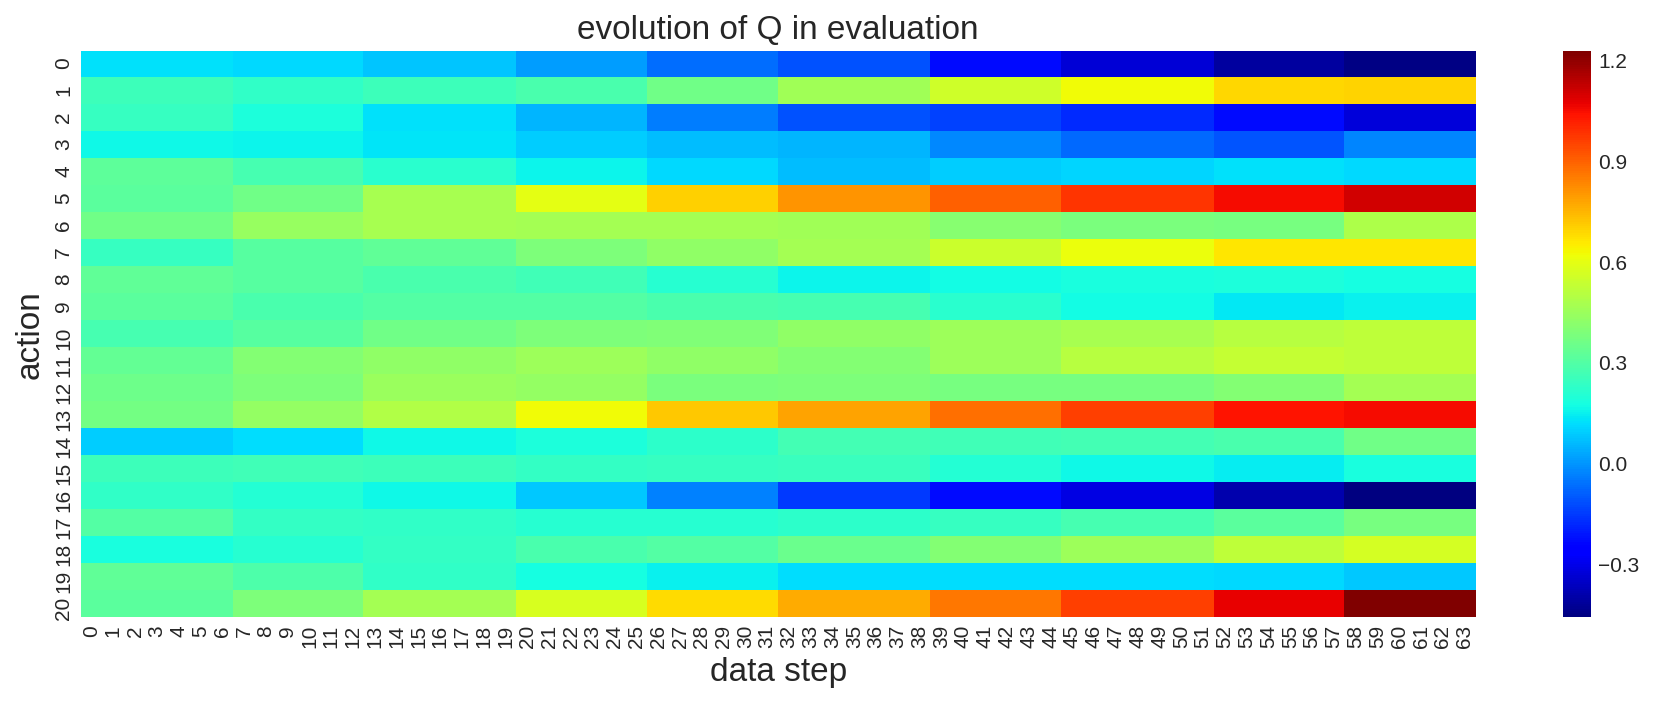

In [14]:
n_steps = 1

import DQN_TIN  # DQN_TINはバッチ学習中にターゲットネットワークを更新できるように改造したDQN．それ以外の点はオリジナルDQNと変わらない．
import importlib
importlib.reload(DQN_TIN)  # original DRL code
from keras import optimizers

env = Env_YRTRenewal.YRTRenewal(term=TERM, n_agents=64)

model = DQN_TIN.gen_model(input_shapes=env.shapes(), n_outputs=21, \
                           hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                           duel=False, duel_value_dim=8, duel_advantage_dim=16, 
                           input_reg=False, input_min=0, input_max=1,
                           output_reg=False, output_min=0, output_max=1)

#df = pd.DataFrame()
for lr, eps, boltzmann in itertools.product([1e-3,], [1.0,], [False,]):
    print('======================================================')
    print('lr={}, eps={}, boltzmann={}'
          .format(lr, eps, boltzmann))
    
    tester = DQN_TIN.Tester(env, model, exp_buffer_size=10**6)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps,
                training_interval=n_steps, n_batches=n_batches(n_steps), batch_size=256, alpha=1.0, 
                target_update_interval=10, doubleQ=False,
                gamma=1.0, optimizer=optimizers.Adam(lr),
                epsilon_start=1.0, epsilon_end=eps, epsilon_interval=n_steps,
                boltzmann=boltzmann, 
                verbose=False, verbose_interval=100, evaluate_interval=n_steps, 
                warmup_steps=n_steps-2, 
                get_log=True)

    viz = DQN_TIN.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        df_temp['n_steps'] = n_steps
        #df_temp['eps'] = eps
        #df_temp['boltzmann'] = boltzmann
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr=0.001, eps=1.0, boltzmann=False
start testing... :  2019-11-06 00:08:07.134100
start trial 1/5 trial...


100%|██████████| 10/10 [00:14<00:00,  1.62it/s]


start trial 2/5 trial...


100%|██████████| 10/10 [00:15<00:00,  1.48it/s]


start trial 3/5 trial...


100%|██████████| 10/10 [00:15<00:00,  1.42it/s]


start trial 4/5 trial...


100%|██████████| 10/10 [00:15<00:00,  1.26it/s]


start trial 5/5 trial...


100%|██████████| 10/10 [00:16<00:00,  1.27it/s]


end testing... :  2019-11-06 00:09:26.017437
loss and reward history


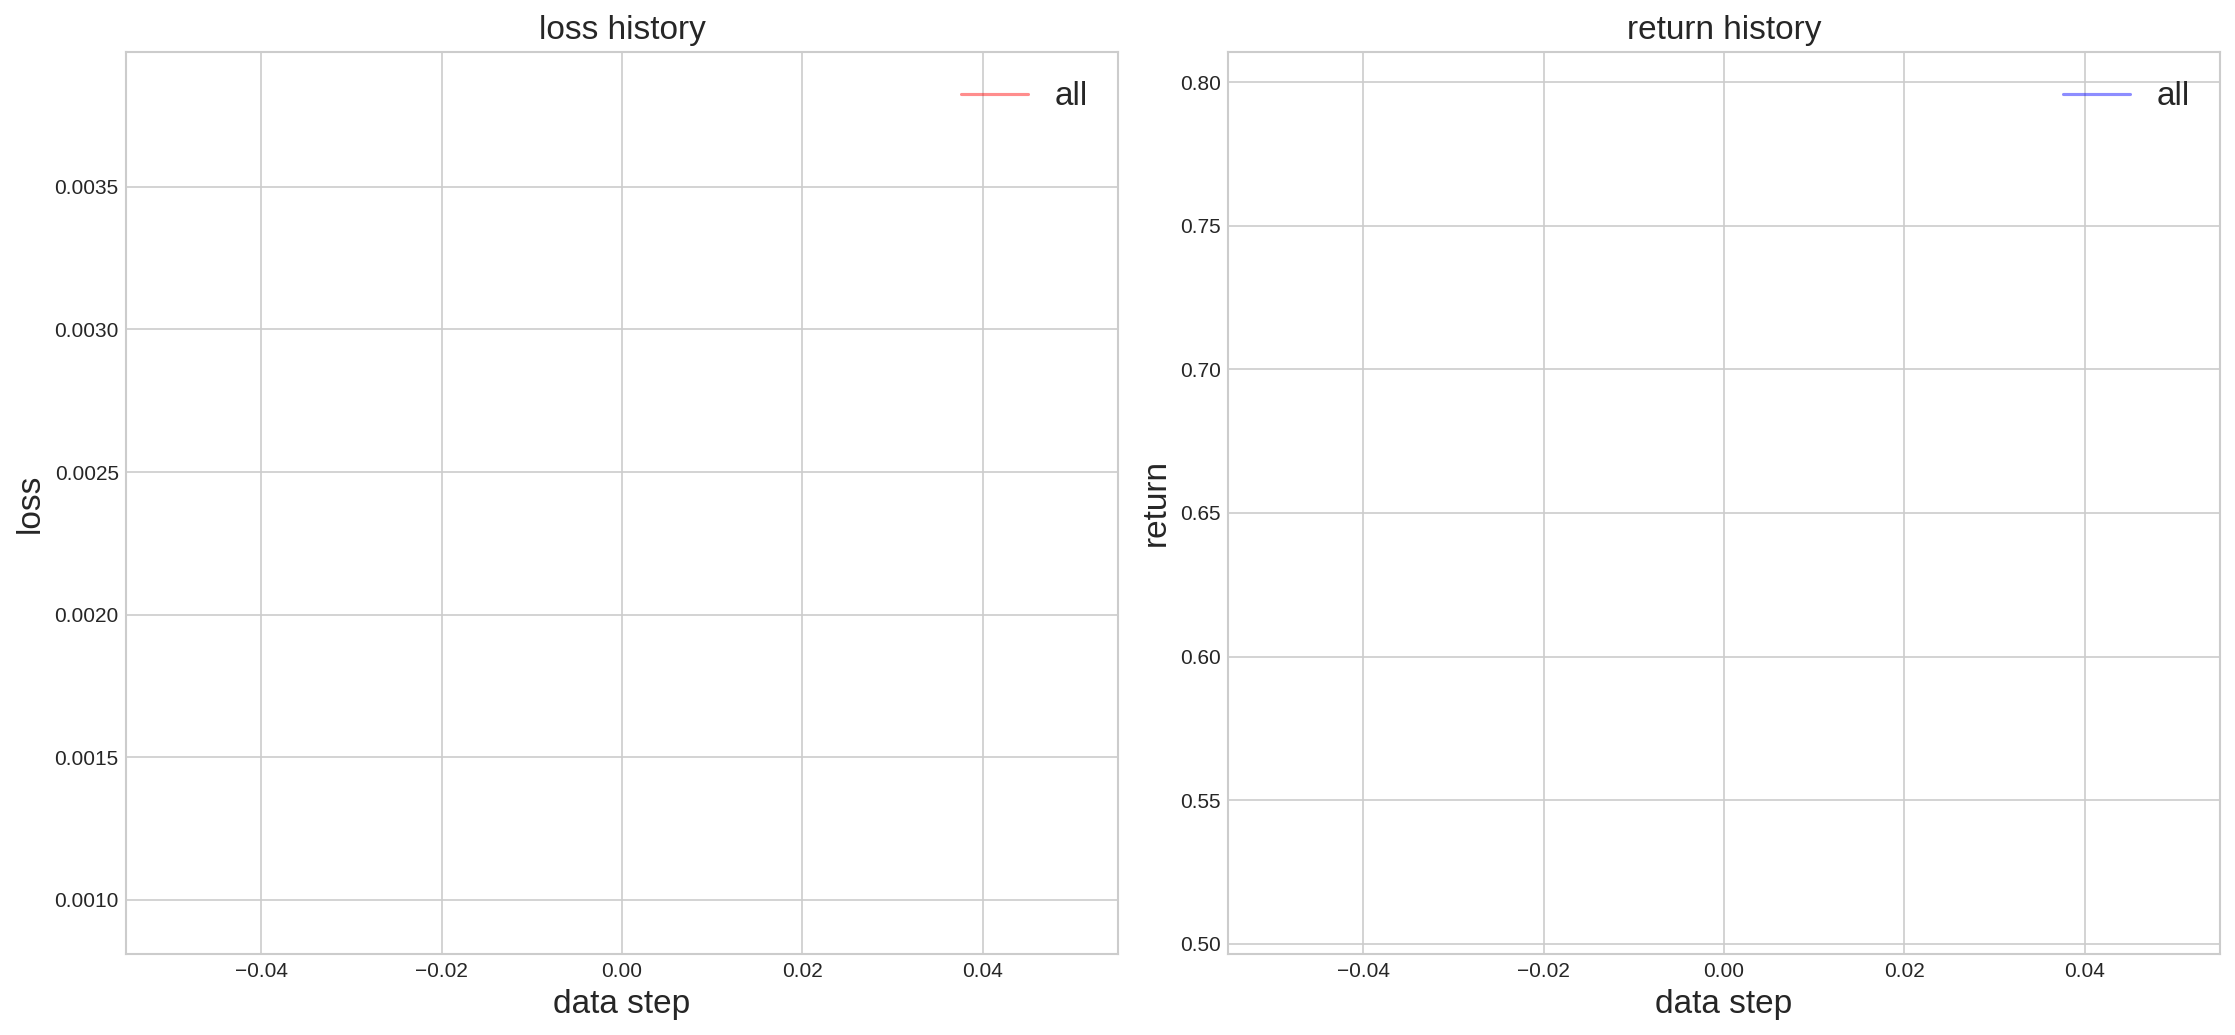

acquired action
action =  [0 0 0 0 0 0 0 0 0 0]
action =  [8 8 8 8 8 8 8 8 8 8]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [6 6 6 6 6 6 6 6 6 6]
return [0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.56]
param distribution in model


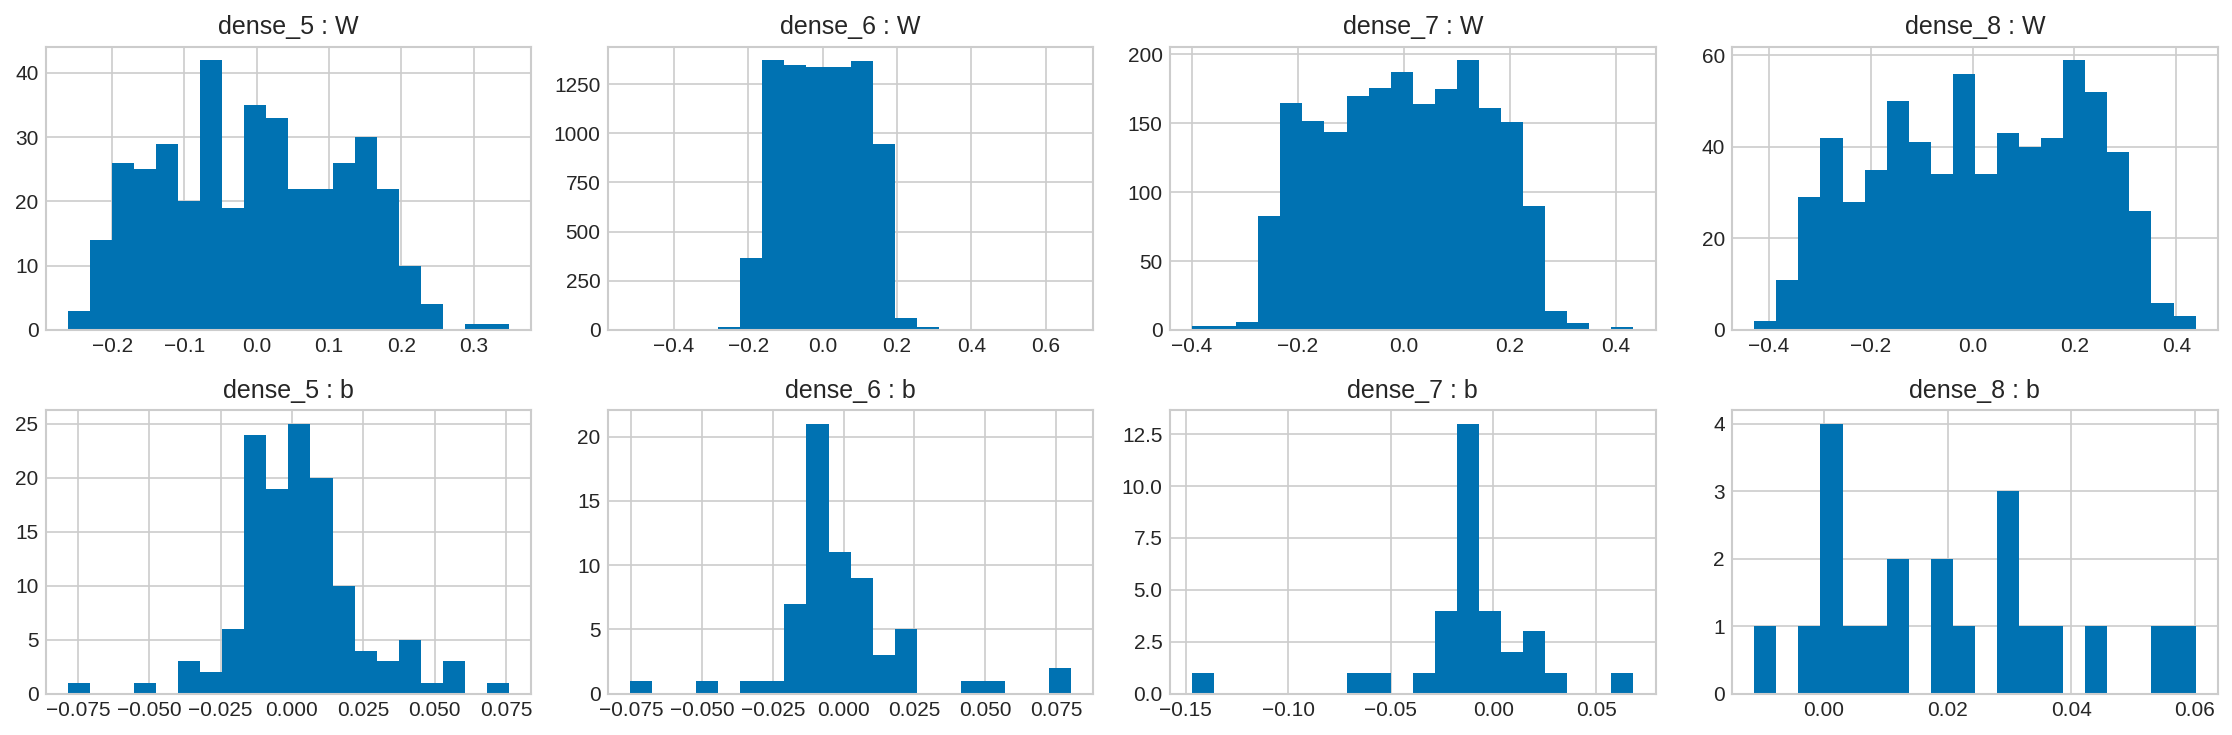

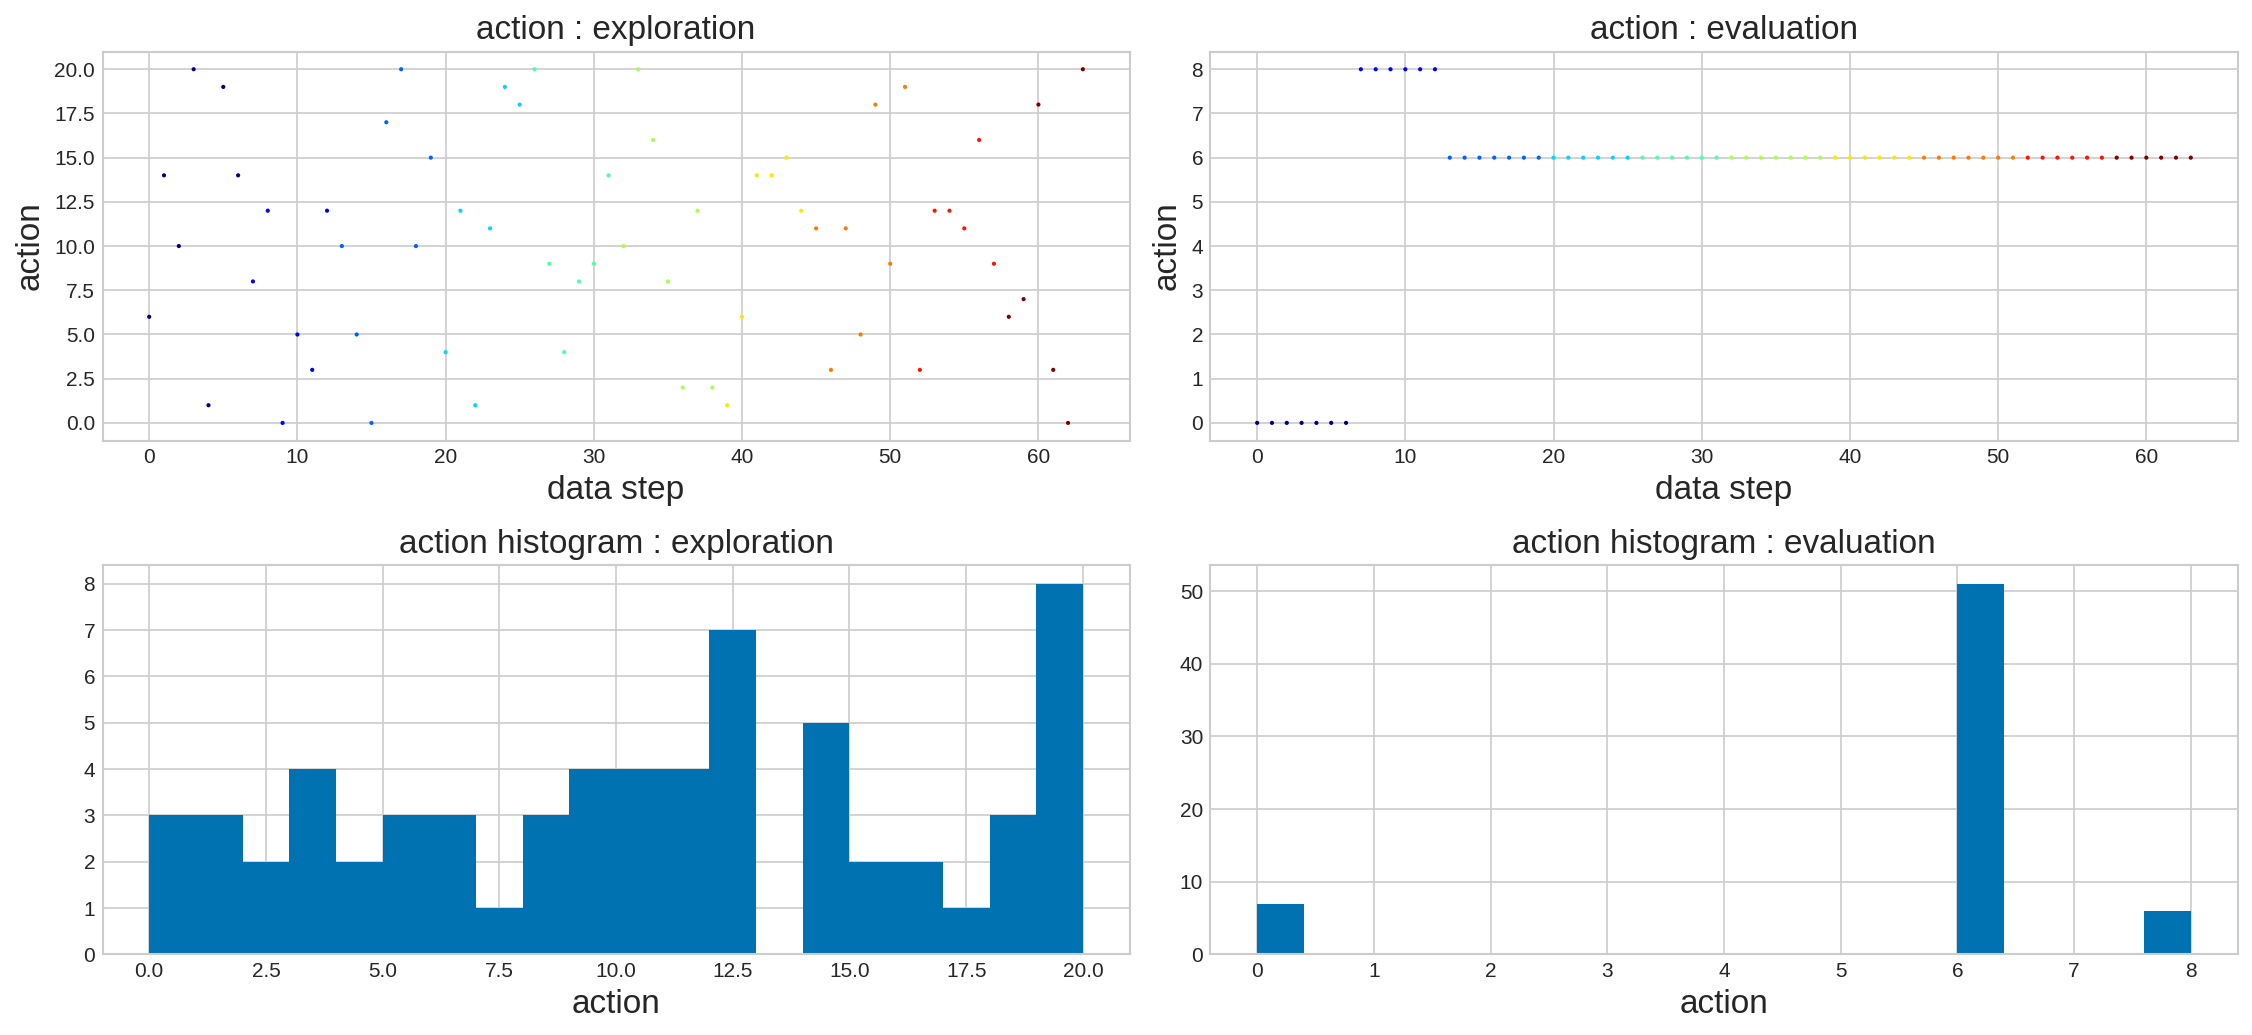

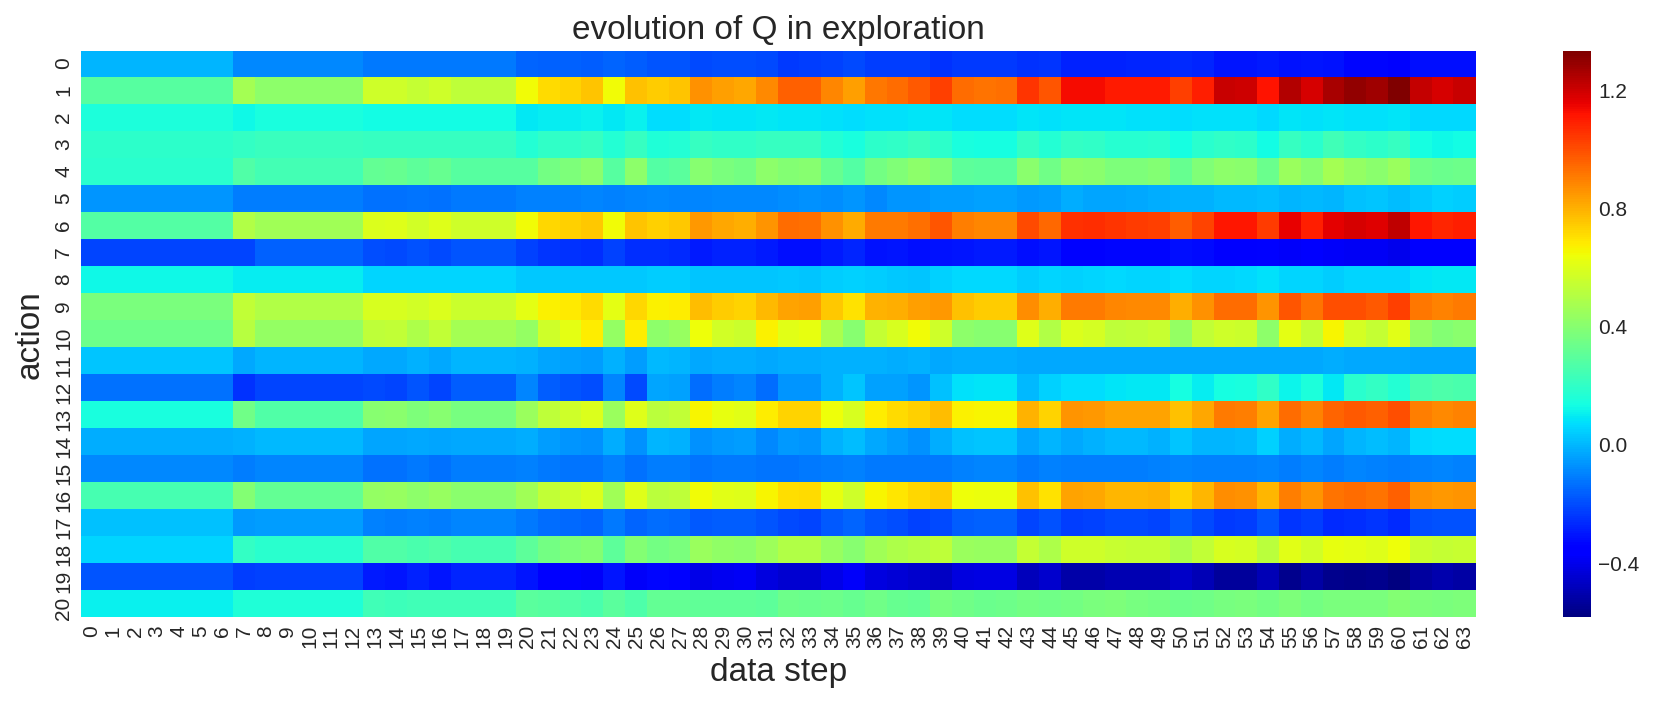

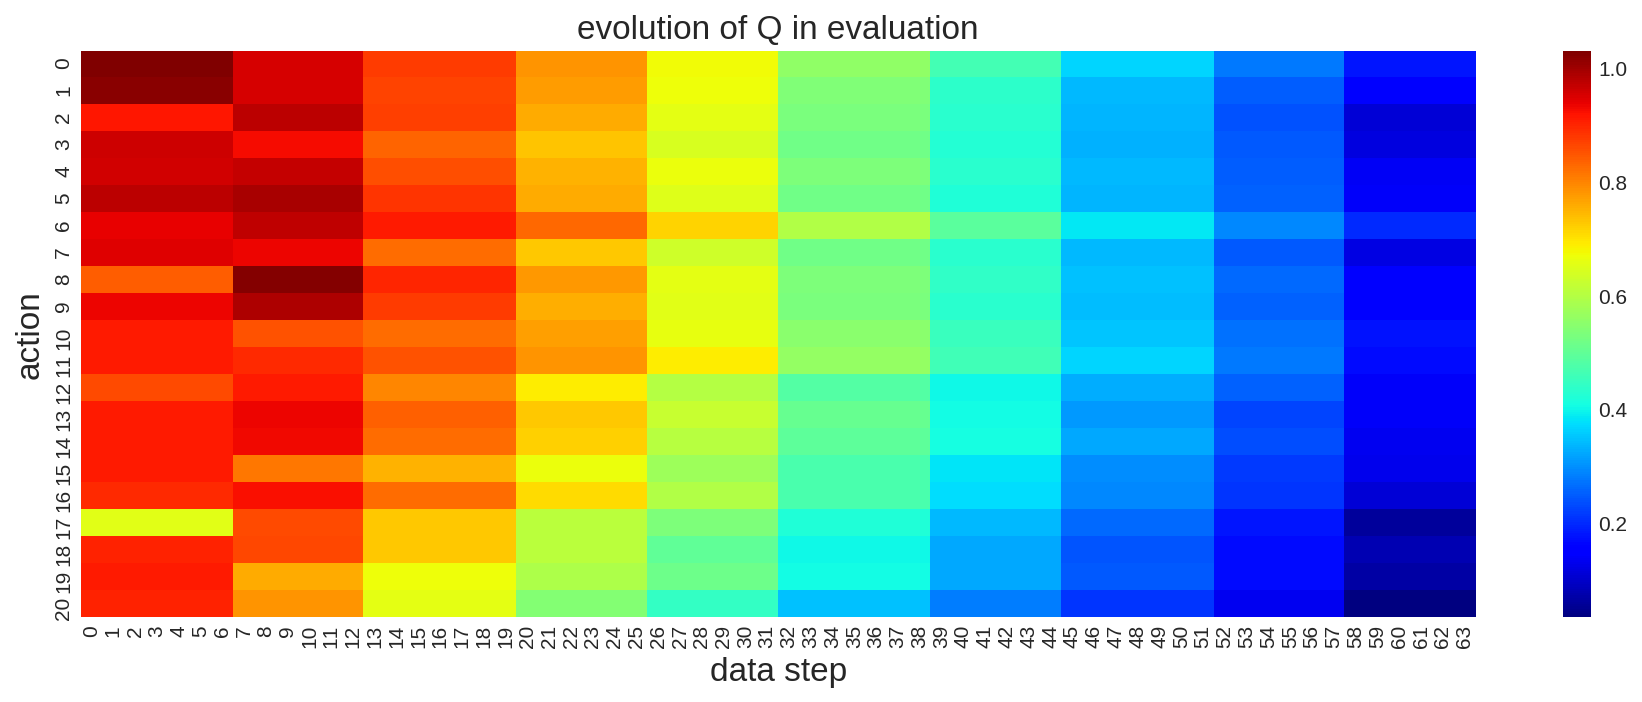

In [15]:
n_steps = 10

import DQN_TIN
import importlib
importlib.reload(DQN_TIN)  # original DRL code
from keras import optimizers

env = Env_YRTRenewal.YRTRenewal(term=TERM, n_agents=64)

model = DQN_TIN.gen_model(input_shapes=env.shapes(), n_outputs=21, \
                           hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                           duel=False, duel_value_dim=8, duel_advantage_dim=16, 
                           input_reg=False, input_min=0, input_max=1,
                           output_reg=False, output_min=0, output_max=1)

#df = pd.DataFrame()
for lr, eps, boltzmann in itertools.product([1e-3,], [1.0,], [False,]):
    print('======================================================')
    print('lr={}, eps={}, boltzmann={}'
          .format(lr, eps, boltzmann))
    
    tester = DQN_TIN.Tester(env, model, exp_buffer_size=10**6)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps,
                training_interval=n_steps, n_batches=n_batches(n_steps), batch_size=256, alpha=1.0, 
                target_update_interval=10, doubleQ=False,
                gamma=1.0, optimizer=optimizers.Adam(lr),
                epsilon_start=1.0, epsilon_end=eps, epsilon_interval=n_steps,
                boltzmann=boltzmann, 
                verbose=False, verbose_interval=100, evaluate_interval=n_steps, 
                warmup_steps=n_steps-2, 
                get_log=True)

    viz = DQN_TIN.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        df_temp['n_steps'] = n_steps
        #df_temp['eps'] = eps
        #df_temp['boltzmann'] = boltzmann
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr=0.001, eps=1.0, boltzmann=False
start testing... :  2019-11-06 00:09:28.681889
start trial 1/5 trial...


100%|██████████| 100/100 [03:19<00:00,  1.11it/s]


start trial 2/5 trial...


100%|██████████| 100/100 [03:17<00:00, 29.70s/it]


start trial 3/5 trial...


100%|██████████| 100/100 [03:23<00:00, 15.43s/it]


start trial 4/5 trial...


100%|██████████| 100/100 [03:30<00:00, 10.73s/it]


start trial 5/5 trial...


100%|██████████| 100/100 [03:36<00:00,  4.90s/it]


end testing... :  2019-11-06 00:26:37.709735
loss and reward history


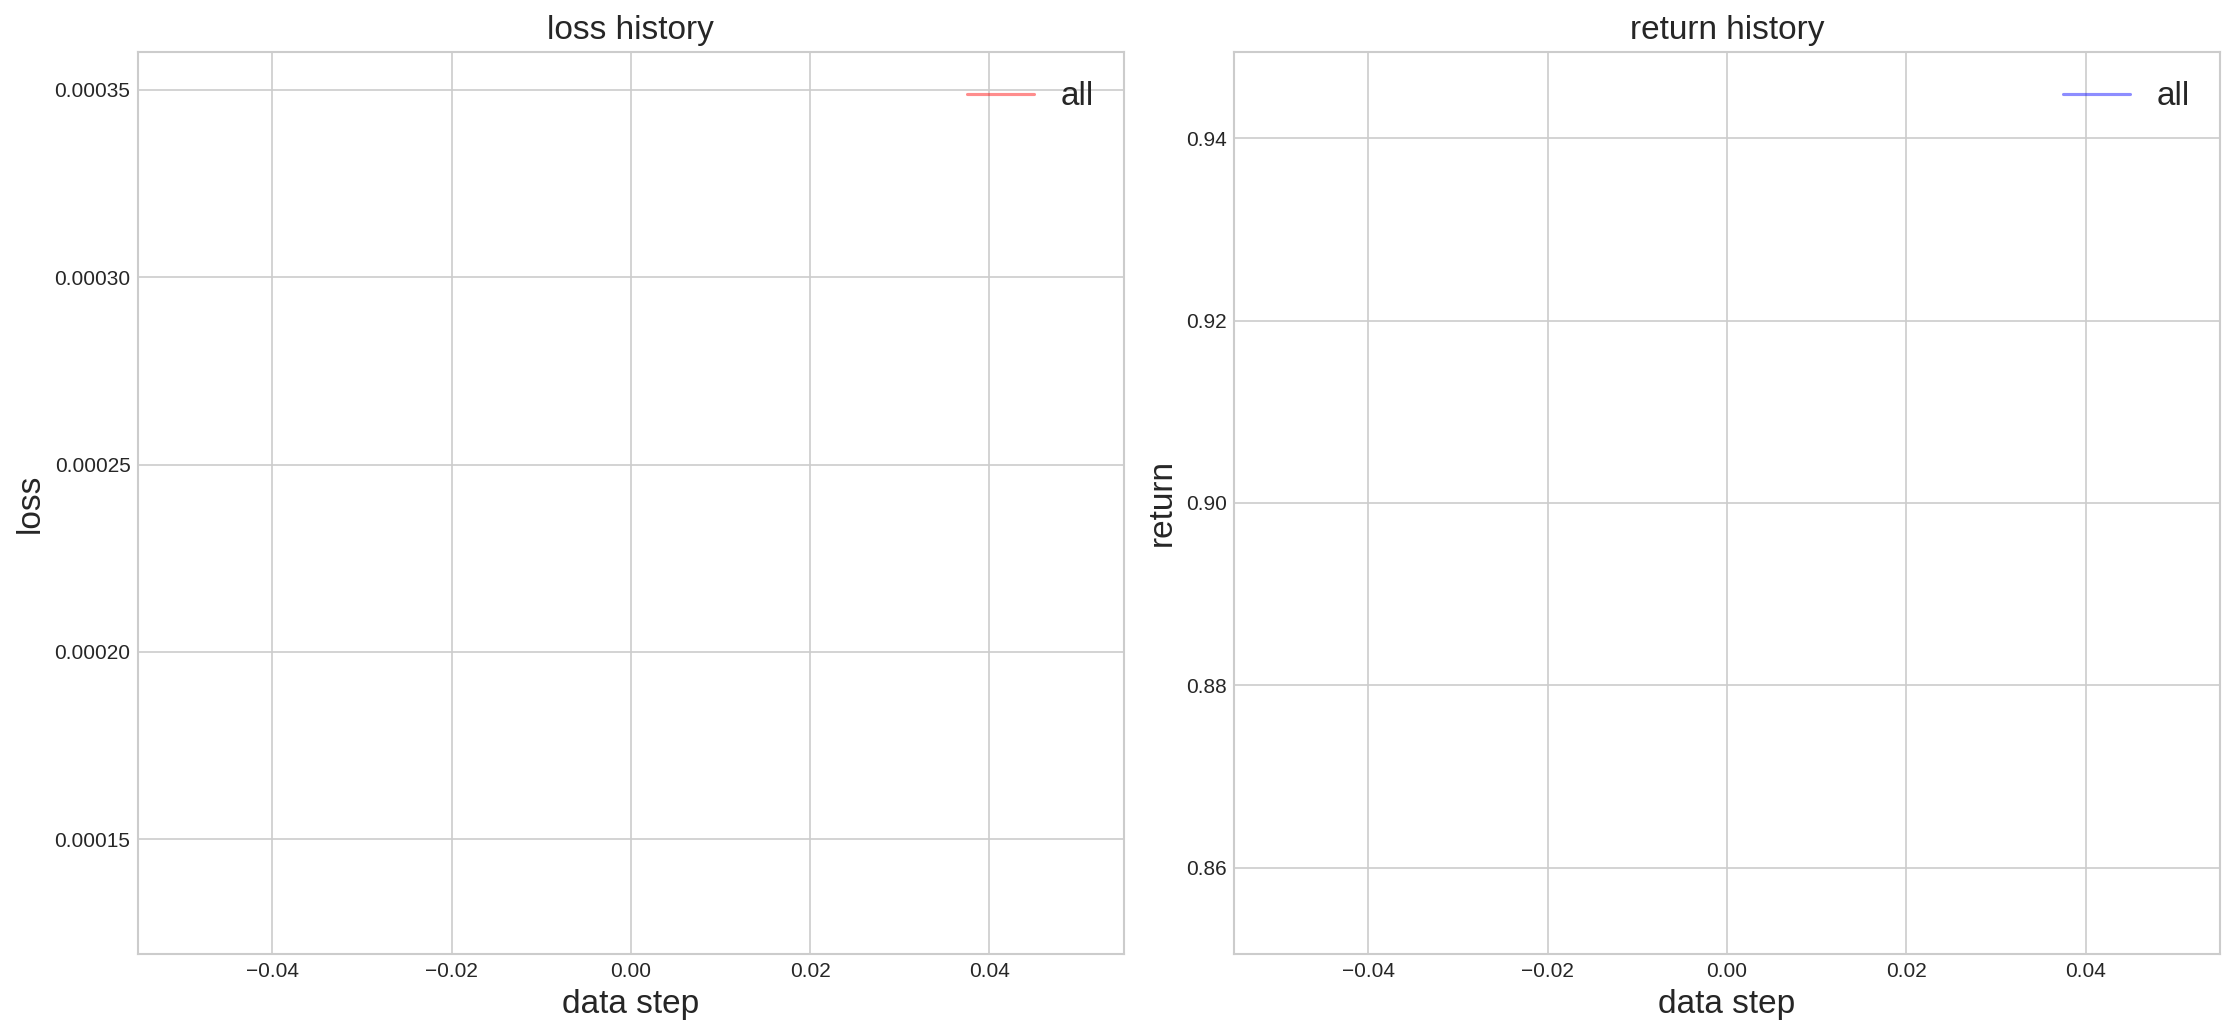

acquired action
action =  [0 0 0 0 0 0 0 0 0 0]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
return [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
param distribution in model


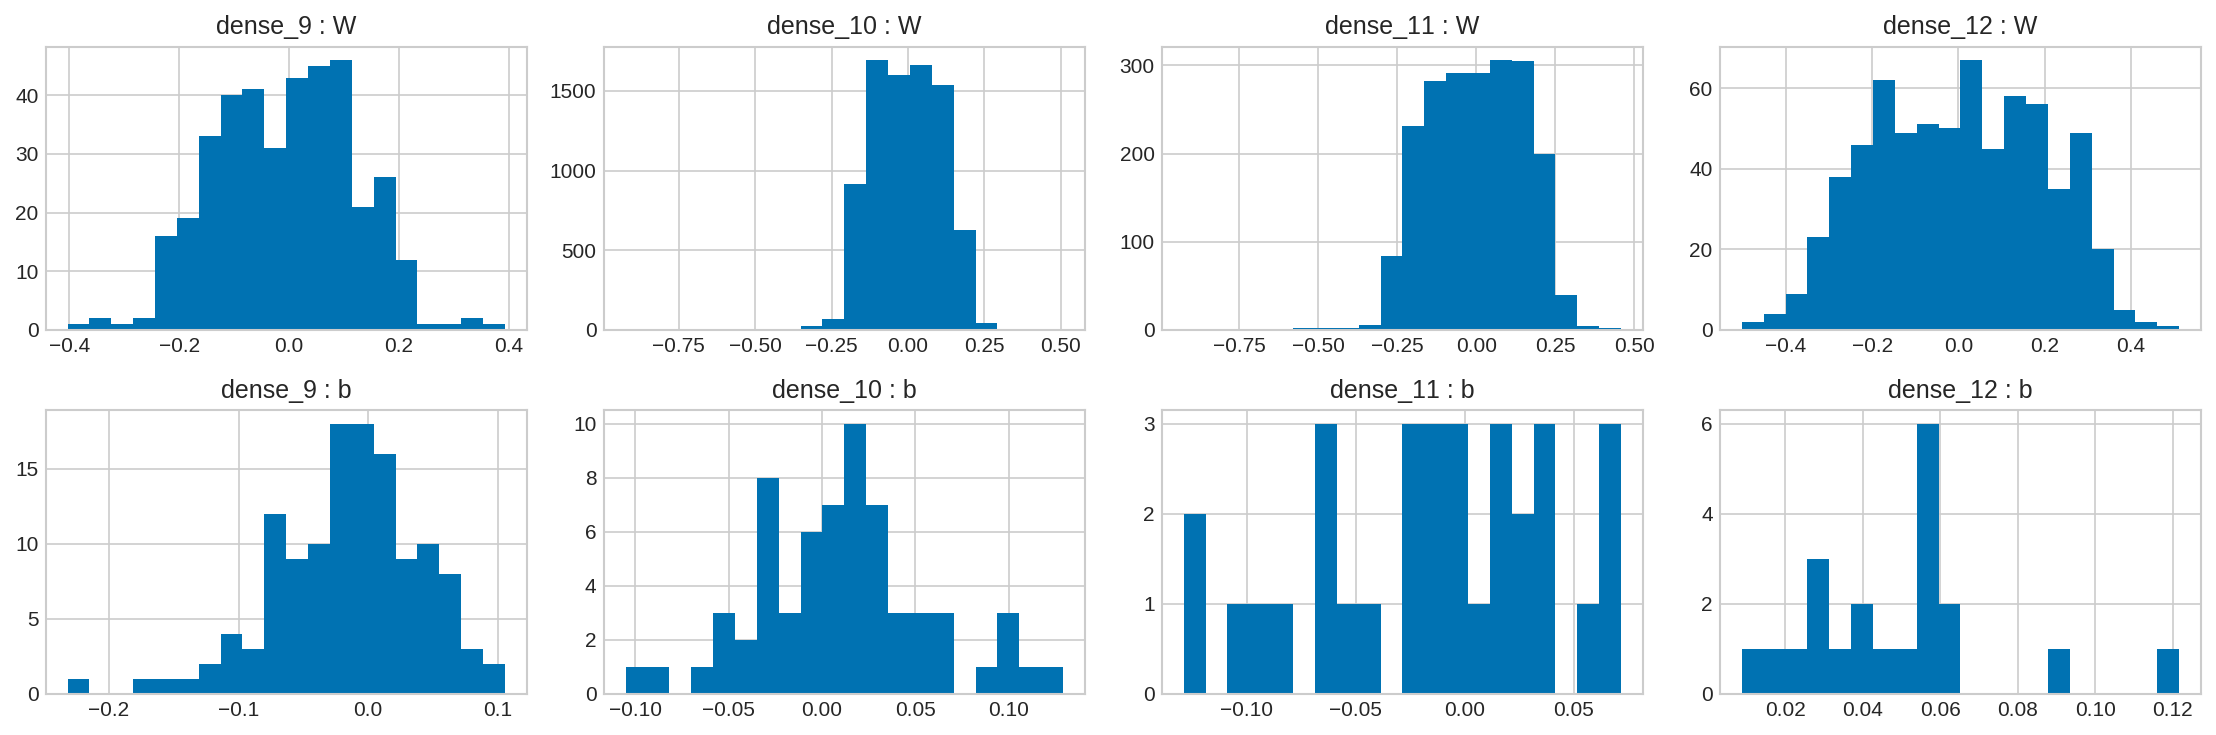

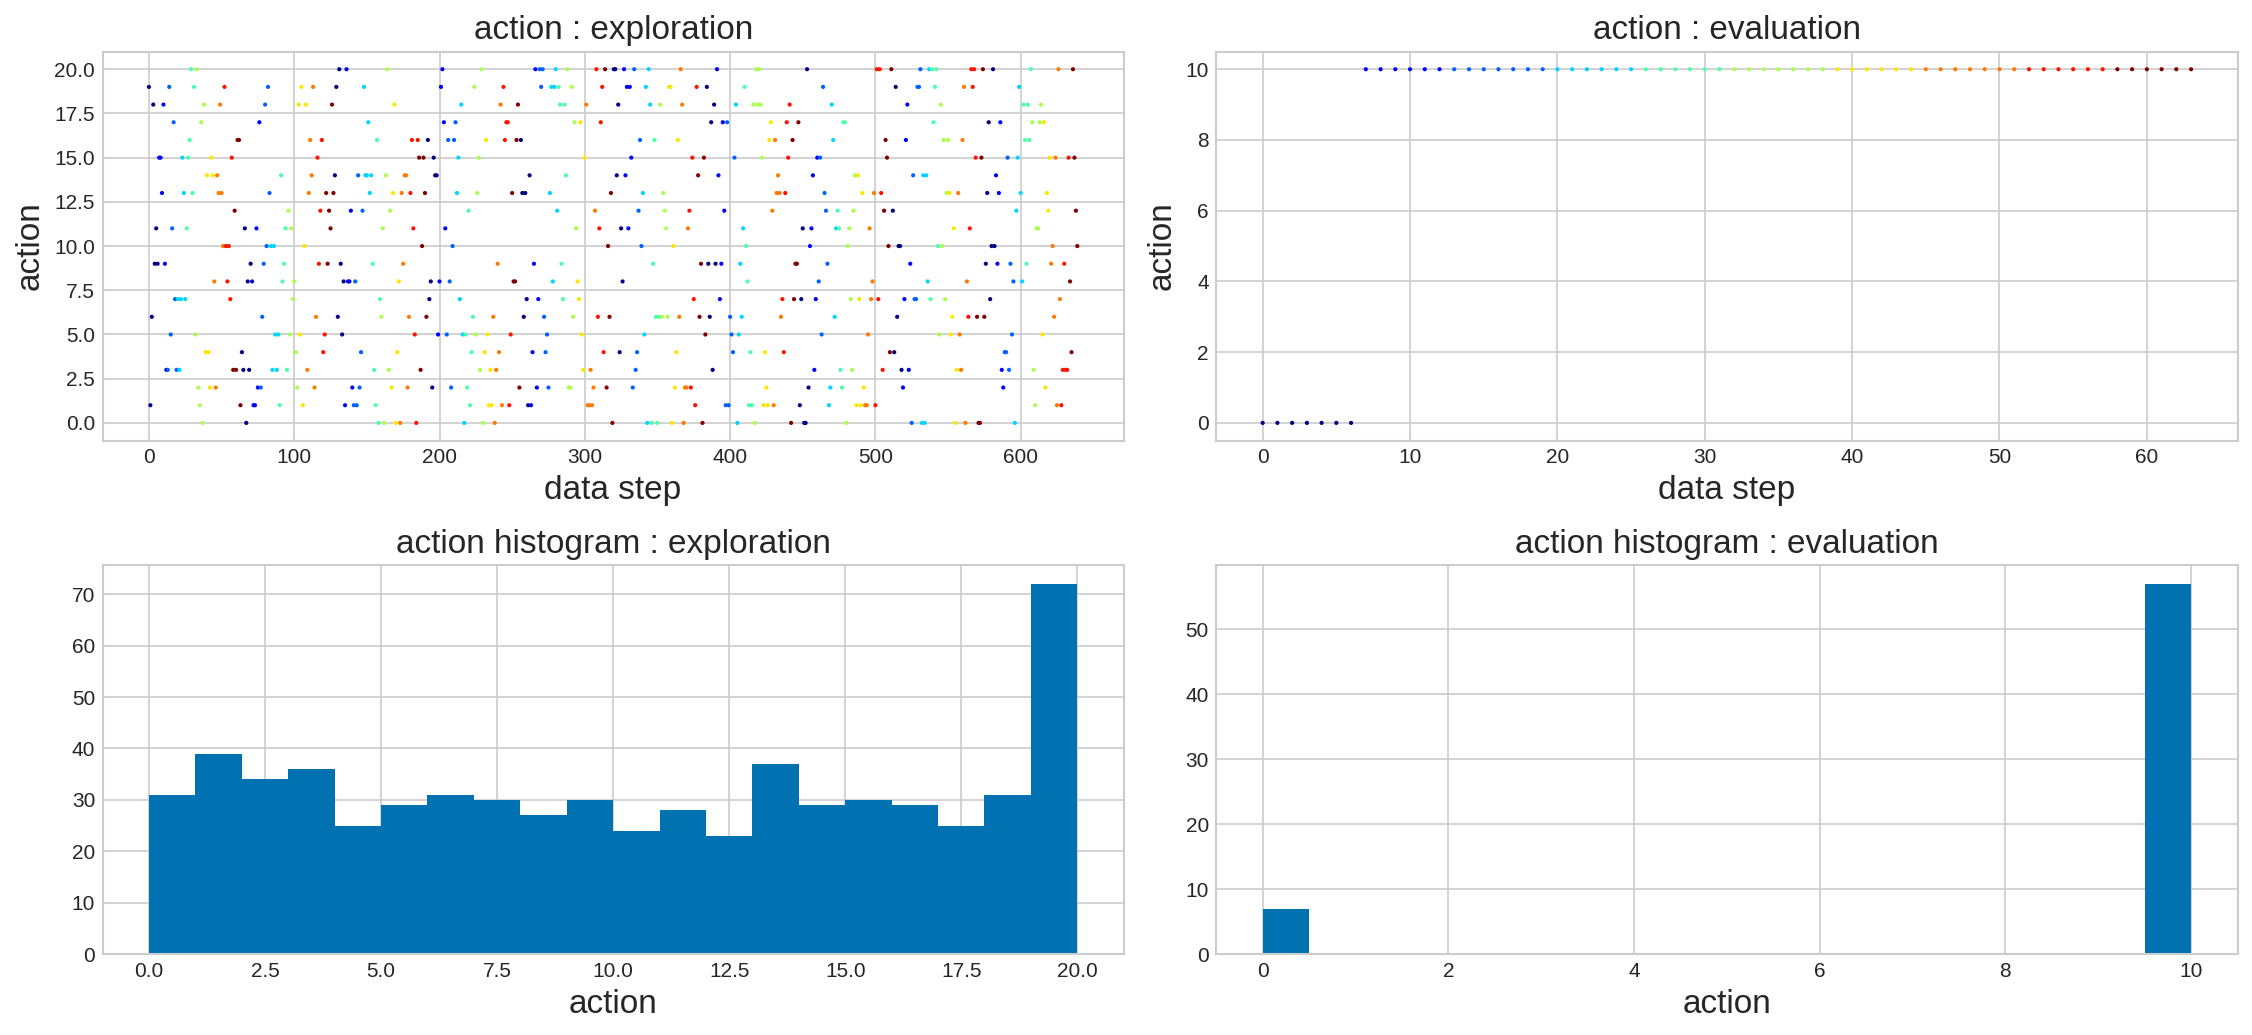

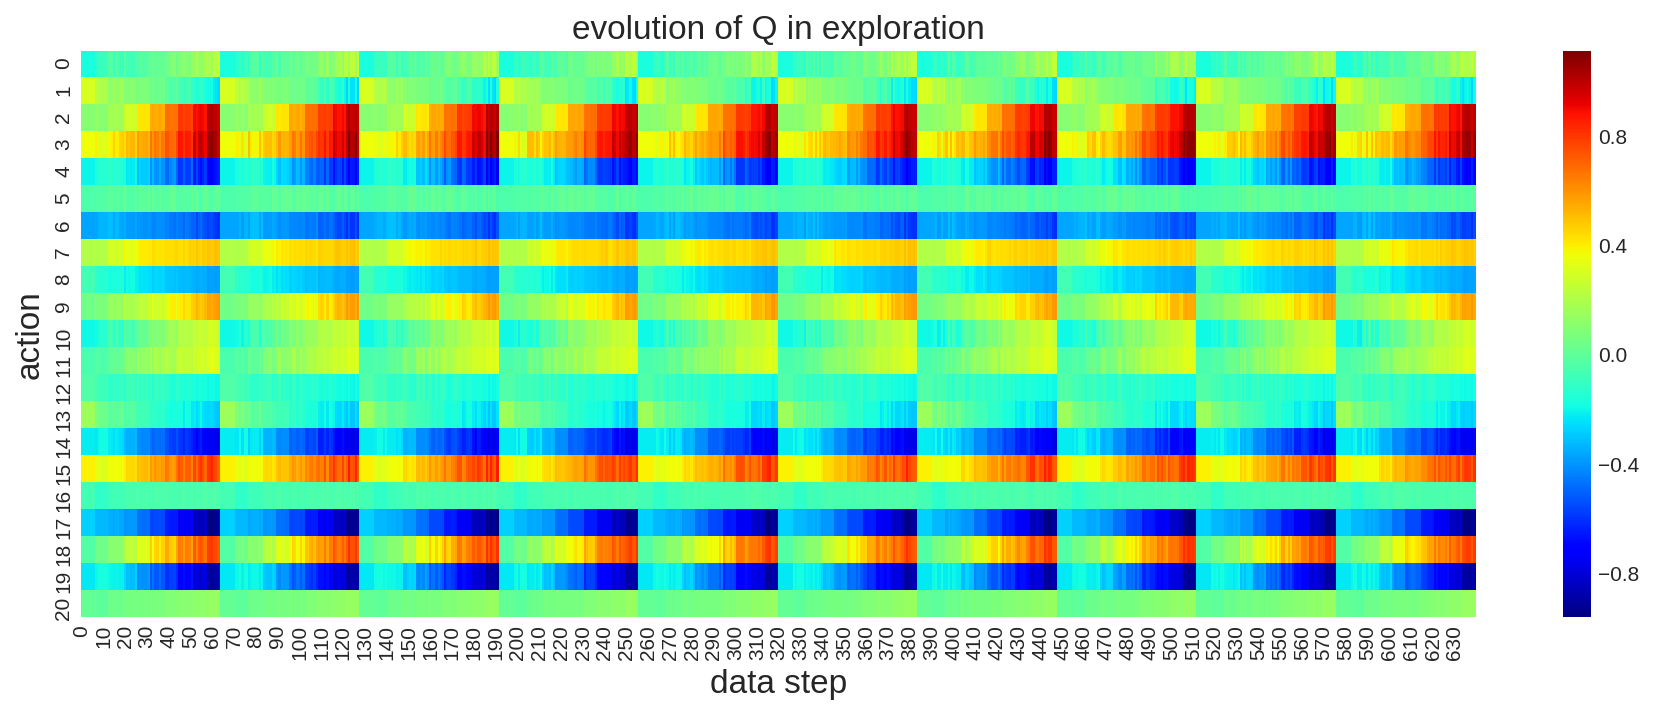

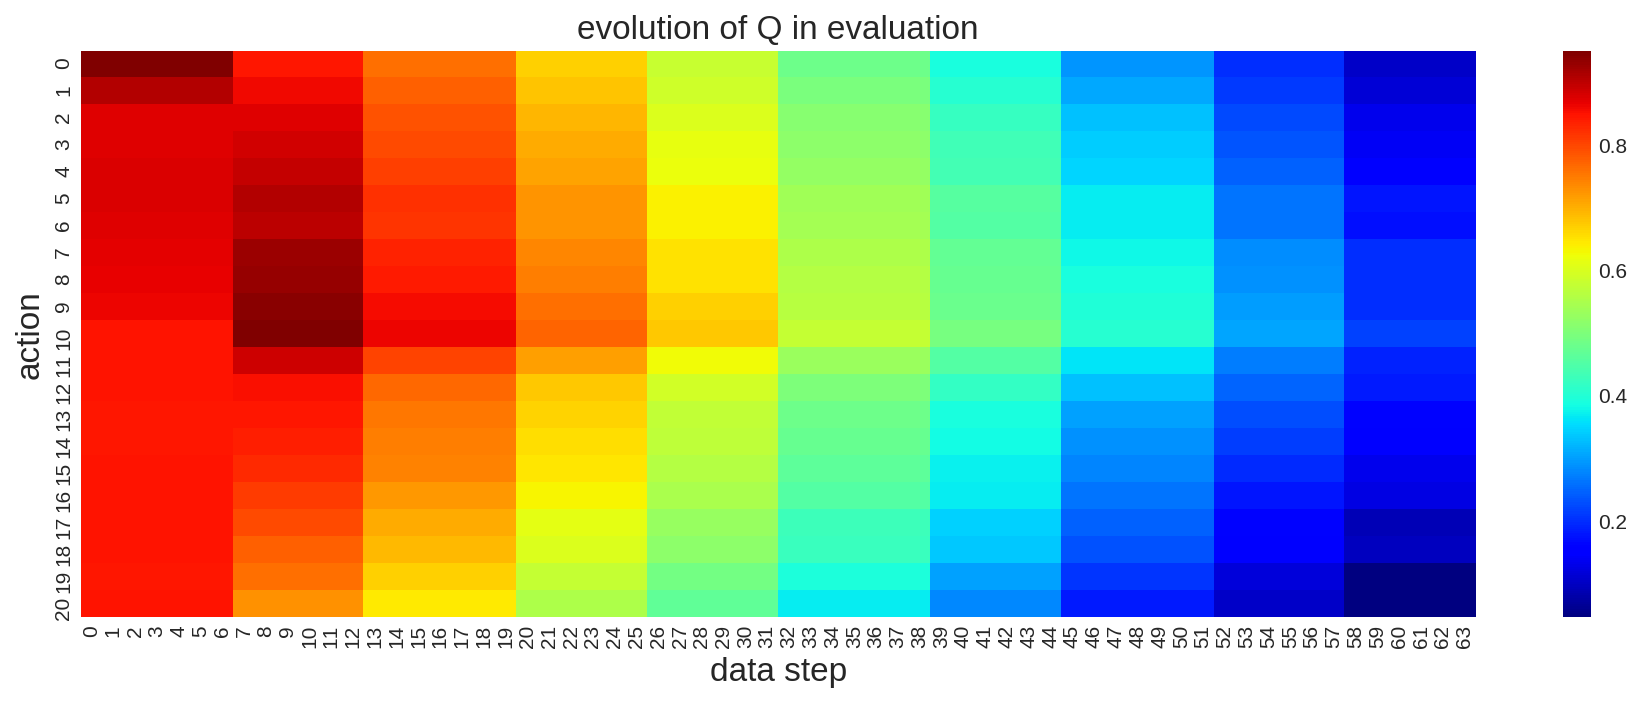

In [16]:
n_steps = 100

import DQN_TIN
import importlib
importlib.reload(DQN_TIN)  # original DRL code
from keras import optimizers

env = Env_YRTRenewal.YRTRenewal(term=TERM, n_agents=64)

model = DQN_TIN.gen_model(input_shapes=env.shapes(), n_outputs=21, \
                           hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                           duel=False, duel_value_dim=8, duel_advantage_dim=16, 
                           input_reg=False, input_min=0, input_max=1,
                           output_reg=False, output_min=0, output_max=1)

#df = pd.DataFrame()
for lr, eps, boltzmann in itertools.product([1e-3,], [1.0,], [False,]):
    print('======================================================')
    print('lr={}, eps={}, boltzmann={}'
          .format(lr, eps, boltzmann))
    
    tester = DQN_TIN.Tester(env, model, exp_buffer_size=10**6)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps,
                training_interval=n_steps, n_batches=n_batches(n_steps), batch_size=256, alpha=1.0, 
                target_update_interval=10, doubleQ=False,
                gamma=1.0, optimizer=optimizers.Adam(lr),
                epsilon_start=1.0, epsilon_end=eps, epsilon_interval=n_steps,
                boltzmann=boltzmann, 
                verbose=False, verbose_interval=100, evaluate_interval=n_steps, 
                warmup_steps=n_steps-2, 
                get_log=True)

    viz = DQN_TIN.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        df_temp['n_steps'] = n_steps
        #df_temp['eps'] = eps
        #df_temp['boltzmann'] = boltzmann
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr=0.001, eps=1.0, boltzmann=False
start testing... :  2019-11-06 00:26:40.487536
start trial 1/5 trial...


100%|██████████| 1000/1000 [50:21<00:00, 56.63s/it]


start trial 2/5 trial...


100%|██████████| 1000/1000 [51:07<00:00, 40.00s/it]


start trial 3/5 trial...


100%|██████████| 1000/1000 [52:09<00:00, 17.07s/it]


start trial 4/5 trial...


100%|██████████| 1000/1000 [53:10<00:00, 318.87s/it]


start trial 5/5 trial...


100%|██████████| 1000/1000 [54:05<00:00, 36.05s/it]


end testing... :  2019-11-06 04:47:40.079509
loss and reward history


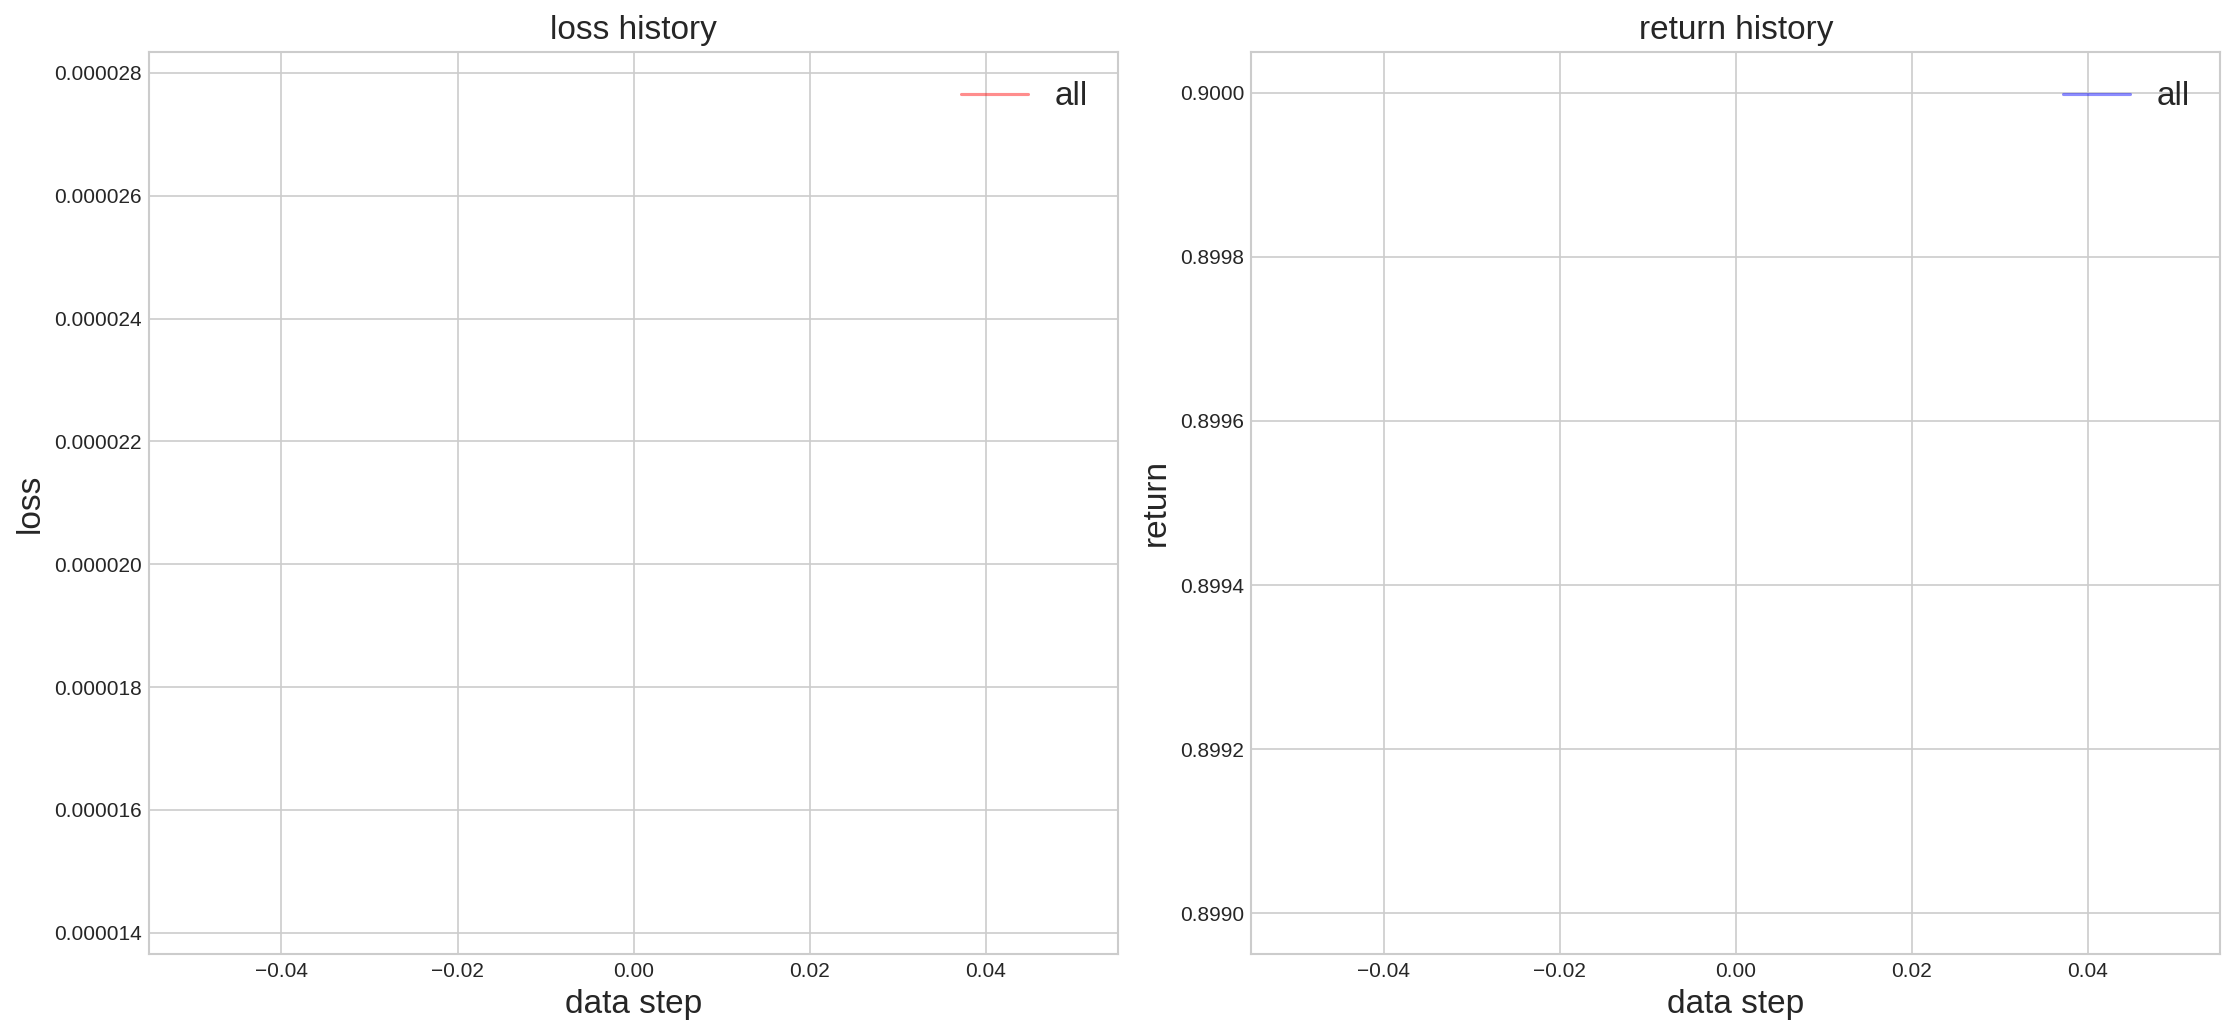

acquired action
action =  [0 0 0 0 0 0 0 0 0 0]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [10 10 10 10 10 10 10 10 10 10]
return [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
param distribution in model


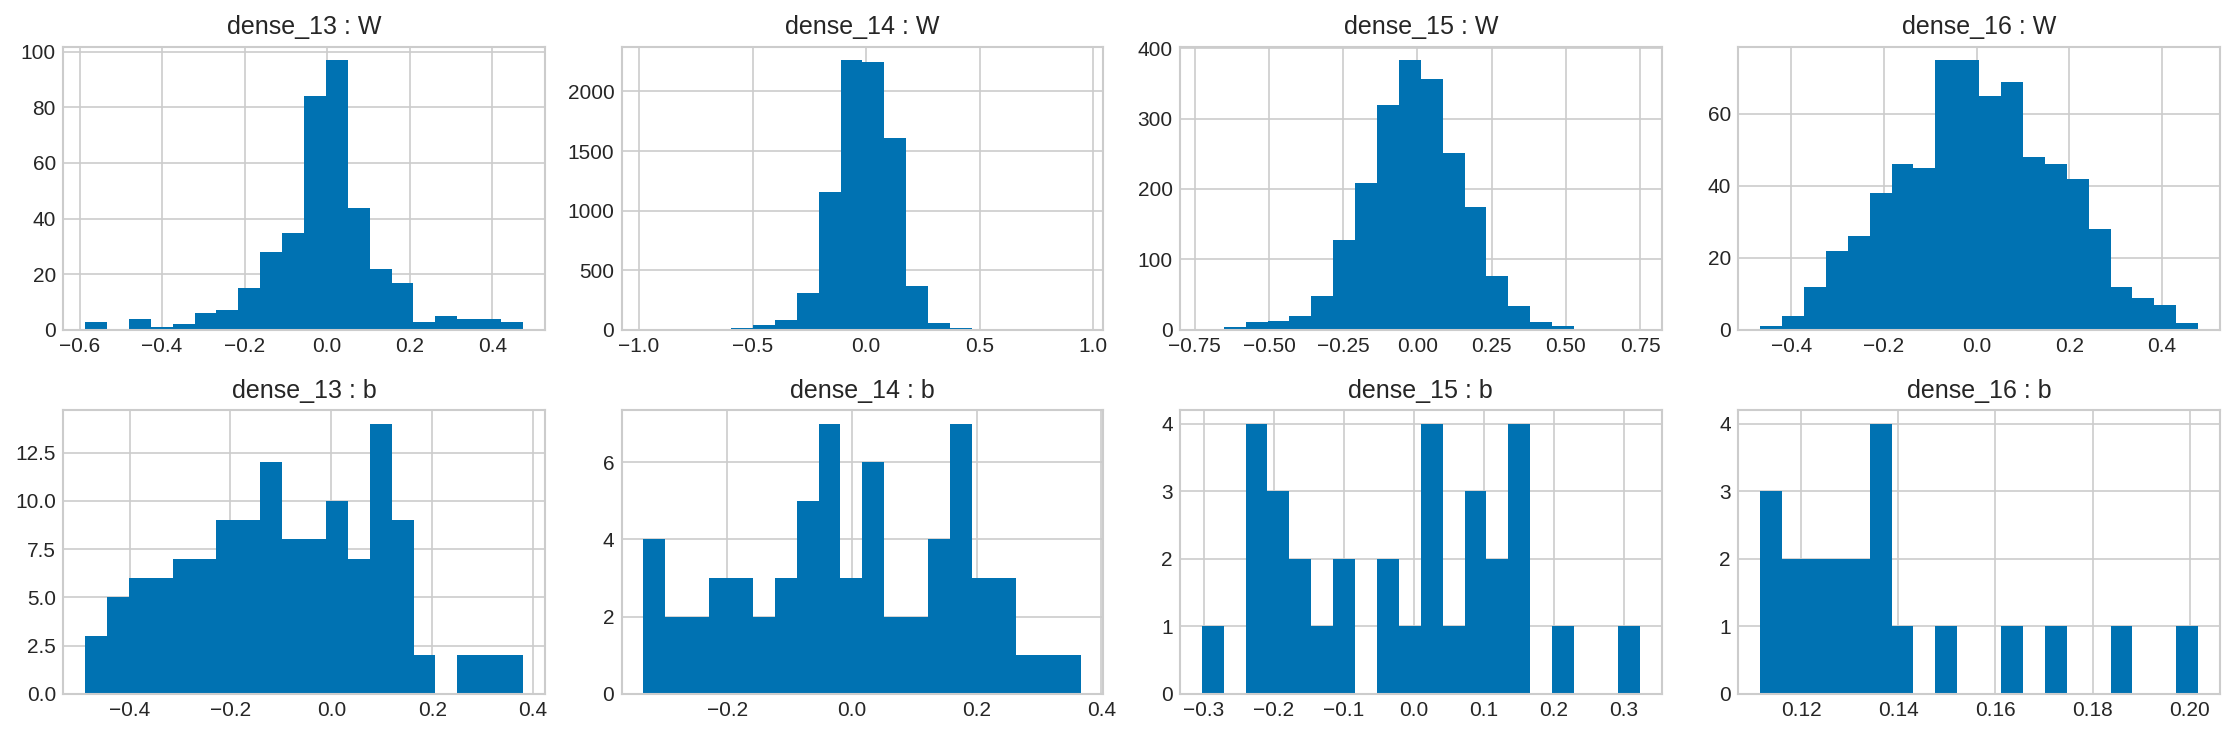

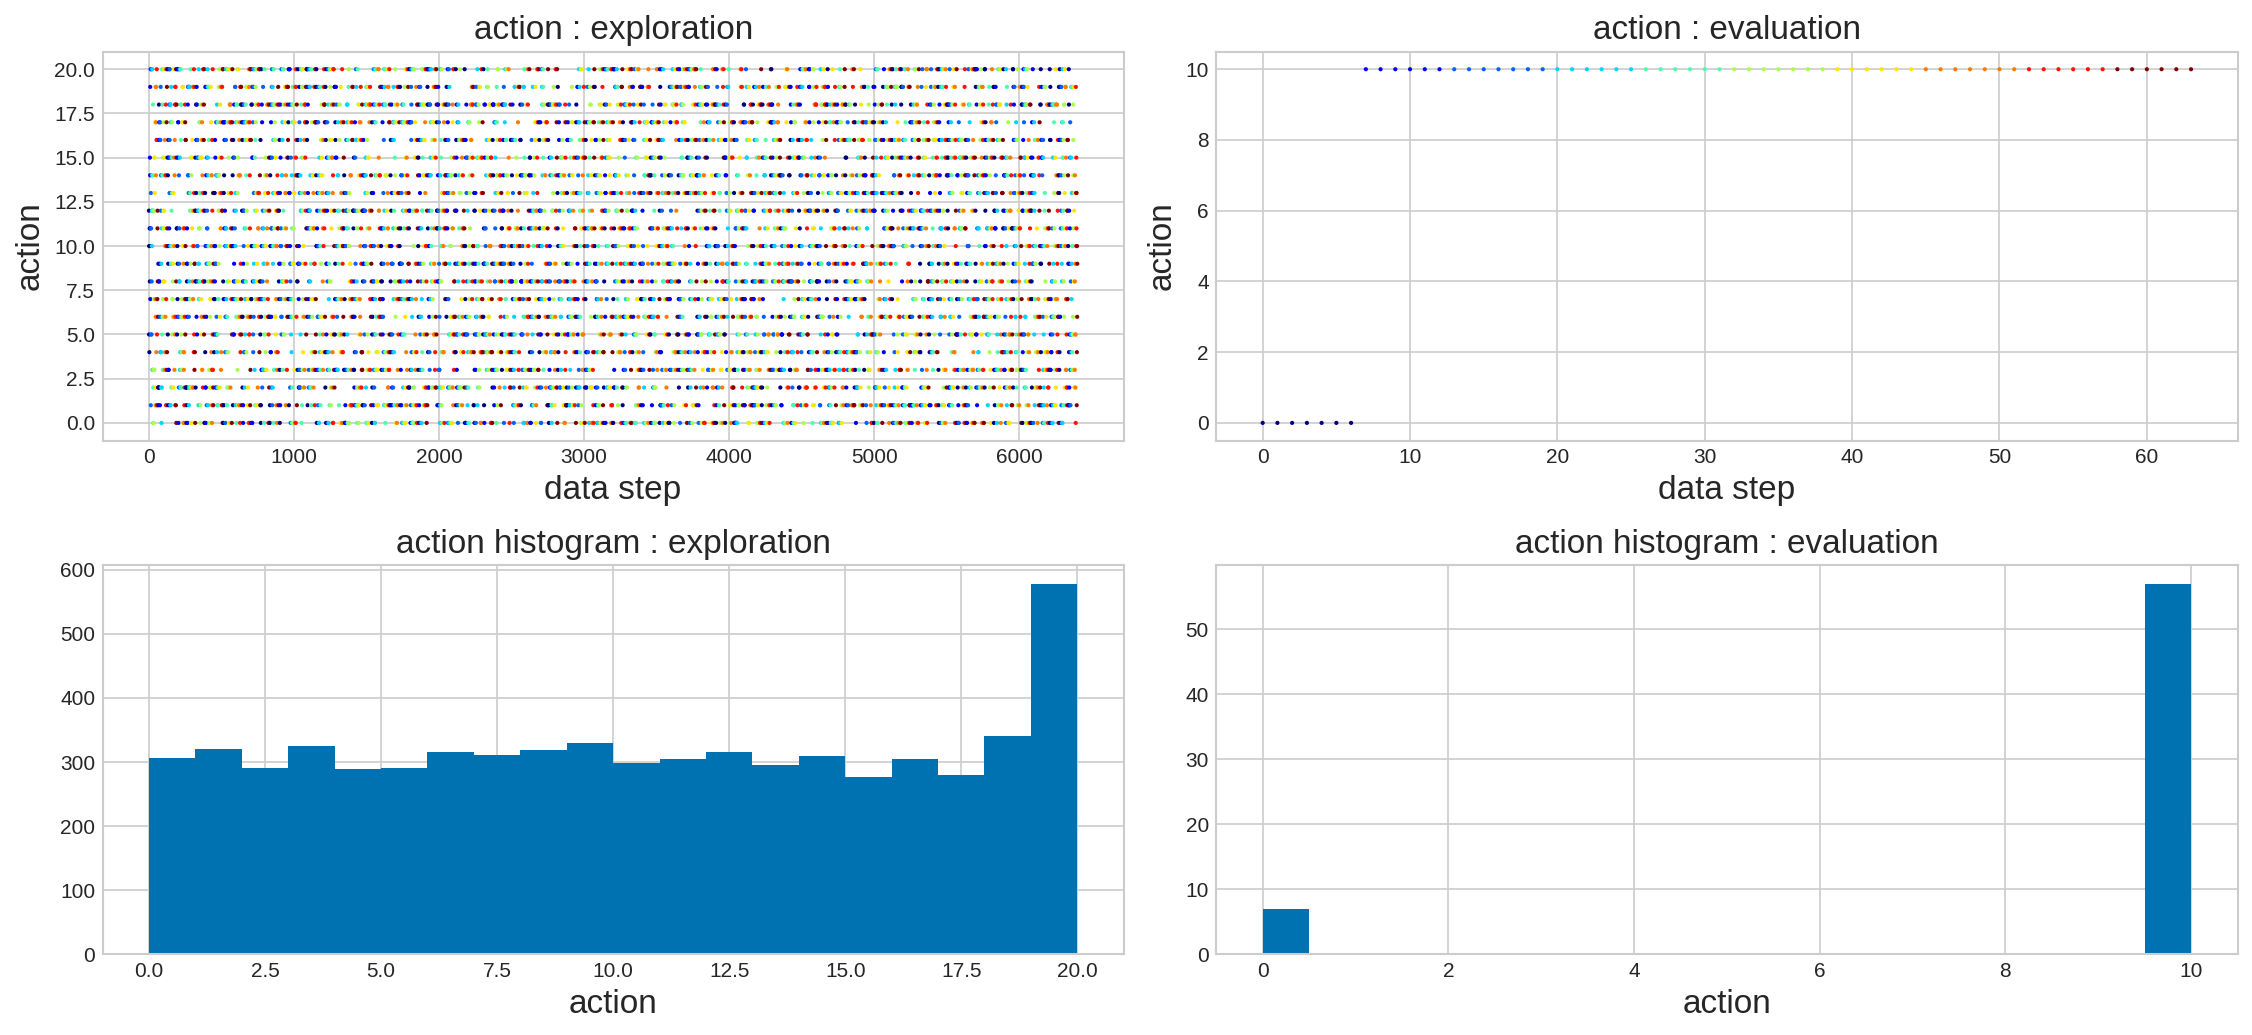

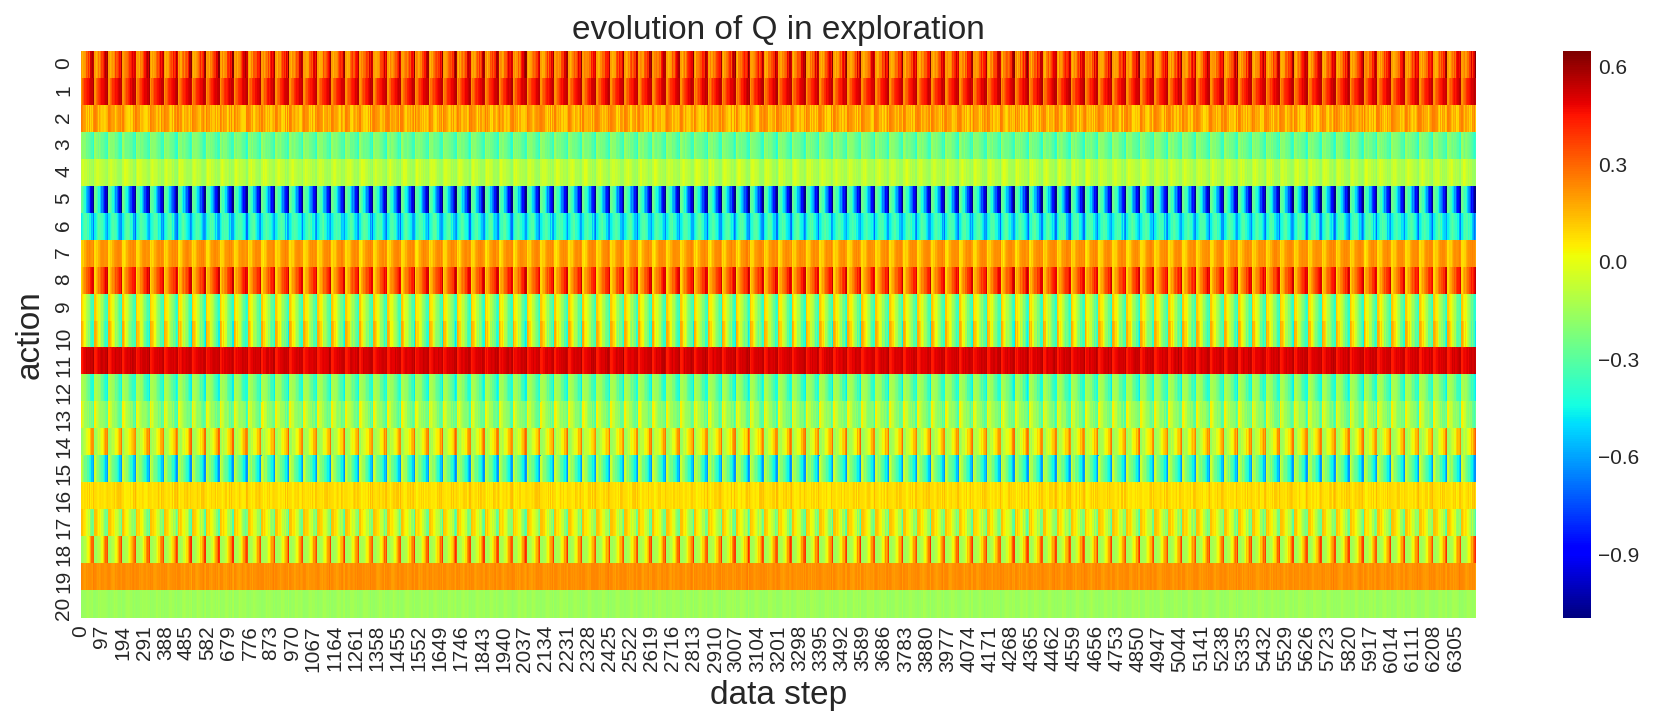

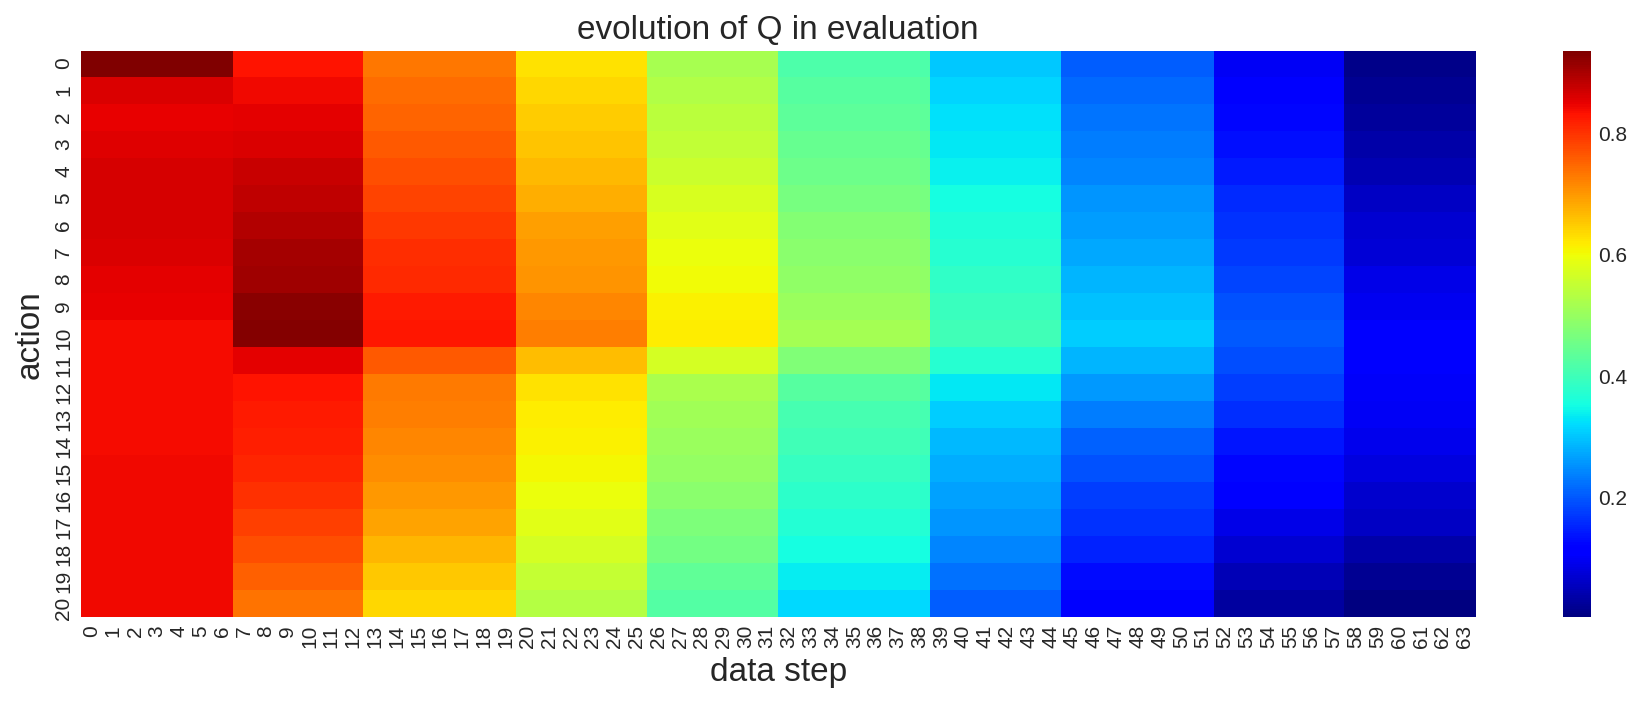

In [17]:
n_steps = 1000

import DQN_TIN
import importlib
importlib.reload(DQN_TIN)  # original DRL code
from keras import optimizers

env = Env_YRTRenewal.YRTRenewal(term=TERM, n_agents=64)

model = DQN_TIN.gen_model(input_shapes=env.shapes(), n_outputs=21, \
                           hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                           duel=False, duel_value_dim=8, duel_advantage_dim=16, 
                           input_reg=False, input_min=0, input_max=1,
                           output_reg=False, output_min=0, output_max=1)

#df = pd.DataFrame()
for lr, eps, boltzmann in itertools.product([1e-3,], [1.0,], [False,]):
    print('======================================================')
    print('lr={}, eps={}, boltzmann={}'
          .format(lr, eps, boltzmann))
    
    tester = DQN_TIN.Tester(env, model, exp_buffer_size=10**6)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps,
                training_interval=n_steps, n_batches=n_batches(n_steps), batch_size=256, alpha=1.0, 
                target_update_interval=10, doubleQ=False,
                gamma=1.0, optimizer=optimizers.Adam(lr),
                epsilon_start=1.0, epsilon_end=eps, epsilon_interval=n_steps,
                boltzmann=boltzmann, 
                verbose=False, verbose_interval=100, evaluate_interval=n_steps, 
                warmup_steps=n_steps-2, 
                get_log=True)

    viz = DQN_TIN.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        df_temp['n_steps'] = n_steps
        #df_temp['eps'] = eps
        #df_temp['boltzmann'] = boltzmann
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

---
## 3. Results

In [18]:
df

return  trial  t  n_steps Agent
0  0.192168      0  0        1   DQN
0  0.538181      1  0        1   DQN
0  0.199674      2  0        1   DQN
0  0.772868      3  0        1   DQN
0  0.215969      4  0        1   DQN
0  0.796474      0  0       10   DQN
0  0.510536      1  0       10   DQN
0  0.728669      2  0       10   DQN
0  0.745417      3  0       10   DQN
0  0.560000      4  0       10   DQN
0  0.900000      0  0      100   DQN
0  0.900000      1  0      100   DQN
0  0.900000      2  0      100   DQN
0  0.900000      3  0      100   DQN
0  0.900000      4  0      100   DQN
0  0.900000      0  0     1000   DQN
0  0.900000      1  0     1000   DQN
0  0.899000      2  0     1000   DQN
0  0.900000      3  0     1000   DQN
0  0.900000      4  0     1000   DQN

In [19]:
pd.options.display.precision = 4
ids = ['n_steps',]
df[df['t'].max()*0.9<=df['t']].groupby(ids)['return'].describe()

count    mean     std     min     25%     50%     75%     max
n_steps                                                               
1          5.0  0.3838  0.2617  0.1922  0.1997  0.2160  0.5382  0.7729
10         5.0  0.6682  0.1251  0.5105  0.5600  0.7287  0.7454  0.7965
100        5.0  0.9000  0.0000  0.9000  0.9000  0.9000  0.9000  0.9000
1000       5.0  0.8998  0.0004  0.8990  0.9000  0.9000  0.9000  0.9000

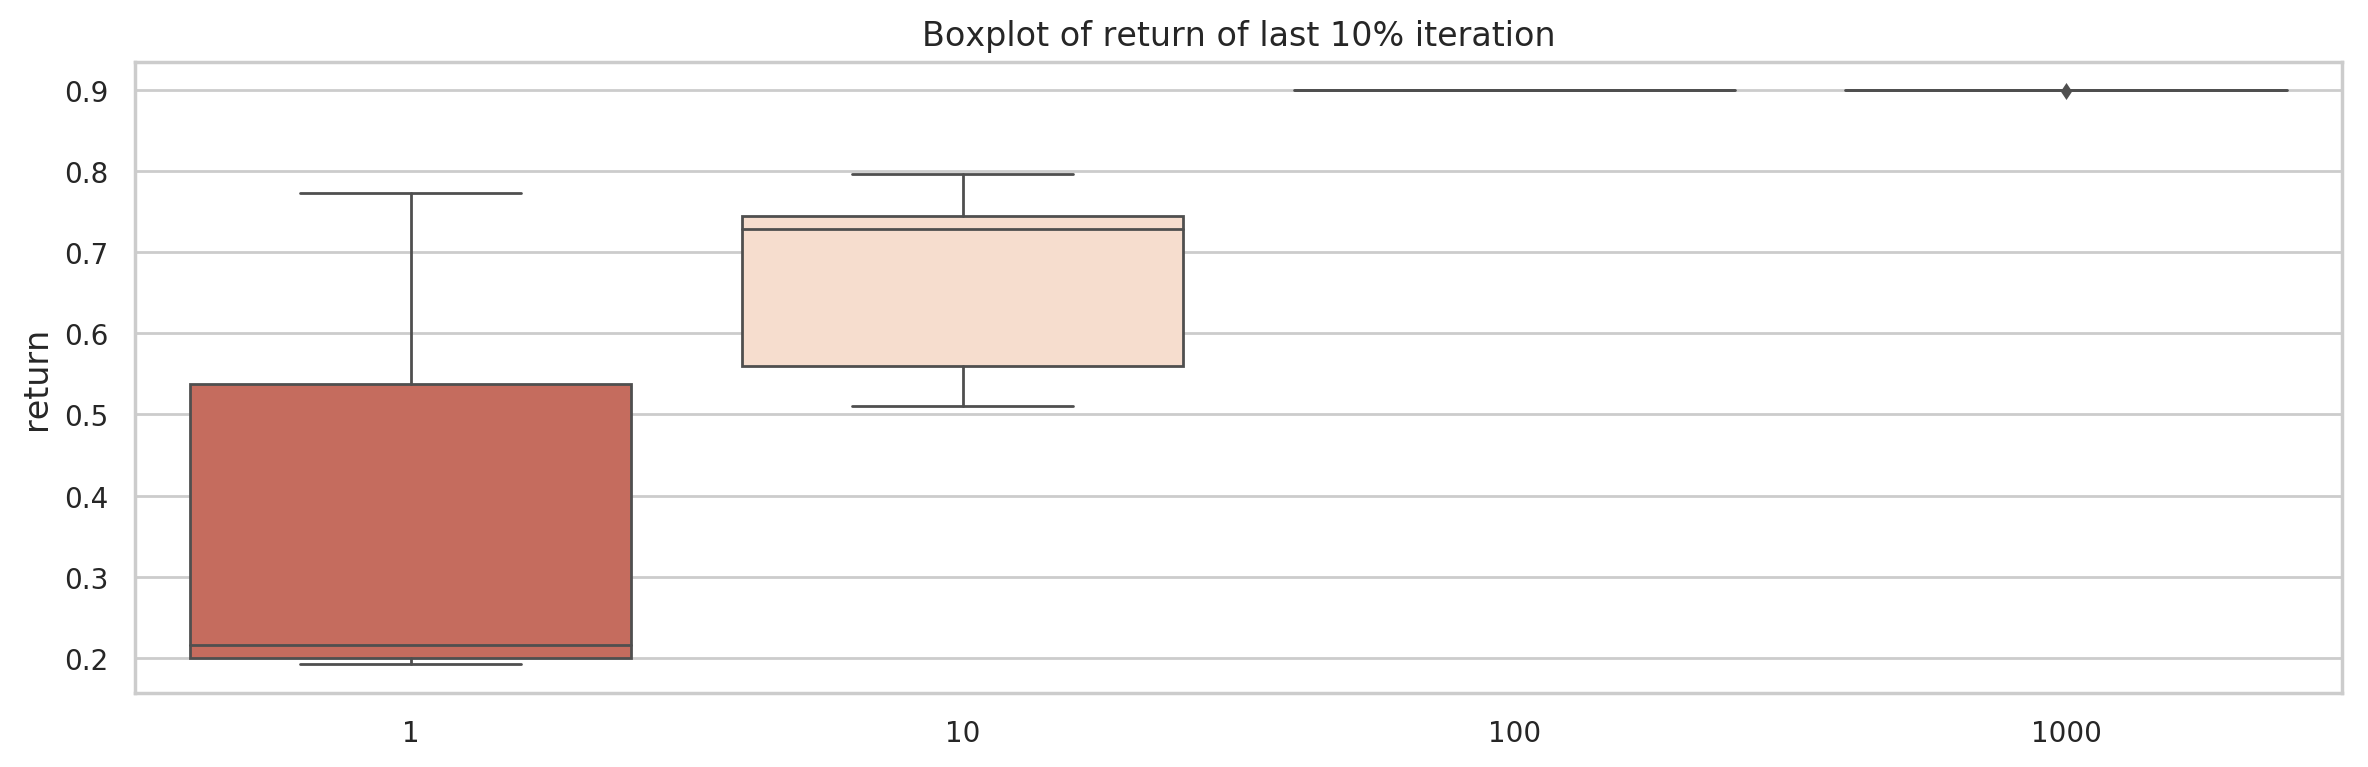

In [20]:
sns.set_style("whitegrid")
sns.set_context("notebook")

plt.figure(figsize=(12, 4), dpi=200)

sns.boxplot(data=df[df['t'].max()*0.9<=df['t']], x='n_steps', y='return', orient='v', fliersize=3.0, linewidth=1.0, palette='RdBu')

plt.title('Boxplot of return of last 10% iteration', fontsize=12)
plt.xlabel('', fontsize=12)
plt.ylabel('return', fontsize=12)
plt.tick_params(labelsize=10)

plt.tight_layout()
plt.show()